In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

### Import libs

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout,BatchNormalization,add
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras import models
from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


#### Config setting

In [2]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'myresnet'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [16, 32, 64] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 200

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 2

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 8

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]
        
		##self.std_scaling = 1.0
		##self.classifier_regr_std = [0.0, 0.0, 0.0, 0.0]
        
		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [3]:
def get_data(input_path):
	"""Parse the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [4]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]
        
        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]
        print(rois)
        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Vgg-16 model

In [5]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        ##return input_length//16
        return input_length//8
    
    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)
    #input_shape = (None, None, 1)
    
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    h0 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(img_input)
    h0 = BatchNormalization()(h0)
    h0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h0)
    h0 = BatchNormalization()(h0)
    block0_out = MaxPooling2D(2)(h0)

    h1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block0_out)
    h1 = BatchNormalization()(h1)
    h1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h1)
    h1 = BatchNormalization()(h1)
    block1_out = MaxPooling2D(2)(h1)

    h2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block1_out)
    h2 = BatchNormalization()(h2)
    h2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h2)
    h2 = BatchNormalization()(h2)
    block2_out = add([h2, block1_out])

    h3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(block2_out)
    h3 = BatchNormalization()(h3)
    h3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='glorot_normal')(h3)
    h3 = BatchNormalization()(h3)
    block3_out = add([h3, block2_out])

    h4 = Conv2D(128, 3, activation='relu',padding='same',kernel_initializer='glorot_normal')(block3_out)
    h4 = BatchNormalization()(h4)
    h4 = MaxPooling2D(2)(h4)
    x = Conv2D(128, 3, activation='relu',padding='same',kernel_initializer='glorot_normal')(h4)

    return x

####  RPN layer

In [6]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

####  Classifier layer

In [7]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    #input_shape = (num_rois,7,7,128)

    pooling_regions = 5

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(256, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(256, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [8]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [9]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 128

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [10]:
def get_new_img_size(width, height, img_min_side=200):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=False):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 1:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 1:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [11]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=False)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				#x_img[:, :, 0] -= C.img_channel_mean[0]
				#x_img[:, :, 1] -= C.img_channel_mean[1]
				#x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= 255.0

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				#y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

#### Define loss functions for all four outputs

In [12]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [13]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [14]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.7, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [15]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



分割线
--
---
# 测试模型

In [16]:
base_path = ''

train_path =  'train_info_c.txt' # Training data (annotation file)

test_path = 'validation_info_c.txt' # Test data (annotation file)

test_base_path = base_path+'validation_image' # Directory to save the test images

num_rois = 2 # Number of RoIs to process at once.

# Augmentation flag
horizontal_flips = True # Augment with horizontal flips in training. 
vertical_flips = True   # Augment with vertical flips in training. 
rot_90 = True           # Augment with 90 degree rotations in training. 

output_weight_path = os.path.join(base_path, 'model/model_frcnn_myresnet.hdf5')

record_path = os.path.join(base_path, 'model/record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = os.path.join(base_path, 'model/myresnet_weights_tf_dim_ordering_tf_kernels.h5')

config_output_filename = os.path.join(base_path, 'model_myresnet_config.pickle')

In [17]:
# Create the config
C = Config()

#C.use_horizontal_flips = horizontal_flips
#C.use_vertical_flips = vertical_flips
#C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [18]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=14954
Spend 0.25 mins to load the data


In [19]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'0': 1503,
 '1': 1506,
 '2': 1554,
 '3': 1473,
 '4': 1458,
 '5': 1480,
 '6': 1534,
 '7': 1450,
 '8': 1506,
 '9': 1490,
 'bg': 0}
Num classes (including bg) = 11
{'1': 0, '0': 1, '9': 2, '6': 3, '3': 4, '5': 5, '7': 6, '8': 7, '4': 8, '2': 9, 'bg': 10}
Config has been written to model_myresnet_config.pickle, and can be loaded when testing to ensure correct results


In [29]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	#img[:, :, 0] -= C.img_channel_mean[0]
	#img[:, :, 1] -= C.img_channel_mean[1]
	#img[:, :, 2] -= C.img_channel_mean[2]
	img /= 255.0
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	#img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	ratio=1.0
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [21]:
num_features = 128

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Tensor("input_5:0", shape=(?, 2, 4), dtype=float32)
Loading weights from model/model_frcnn_myresnet.hdf5


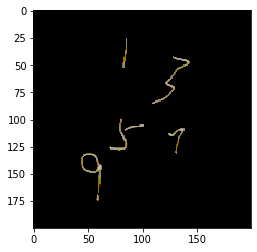

In [38]:
tobe_dir = 'show_img/tobe/'
for idx,name in enumerate(os.listdir(tobe_dir)):
    img = np.clip((255-cv2.resize(cv2.imread(tobe_dir+name),(200,200)))*1,0,255)
    img[img<120] = 0
    cv2.imwrite('show_img/temp/img%d.jpg'%(idx),img.astype('uint8'))
    plt.imshow(img/255)
    plt.show()

In [39]:
# Switch key value for class mapping
#test_base_path = base_path+'test_image' # Directory to save the test images
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

#test_imgs = os.listdir(test_base_path)
test_imgs = os.listdir('show_img/temp')
imgs_path = []
for i in range(len(test_imgs)):
	imgs_path.append(test_imgs[i])
all_imgs = []
classes = {}
len(test_imgs)

X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)
test_imgs, _, _ = get_data(test_path)
data_gen_test = get_anchor_gt(test_imgs, C, get_img_output_length, mode='test')

{0: '1', 1: '0', 2: '9', 3: '6', 4: '3', 5: '5', 6: '7', 7: '8', 8: '4', 9: '2', 10: 'bg'}
Parsing annotation files
idx=5039

img0.jpg
Elapsed time = 0.9153366088867188
[('9', 84.1722846031189), ('3', 84.57427620887756), ('5', 99.32255148887634), ('7', 91.04165434837341)]


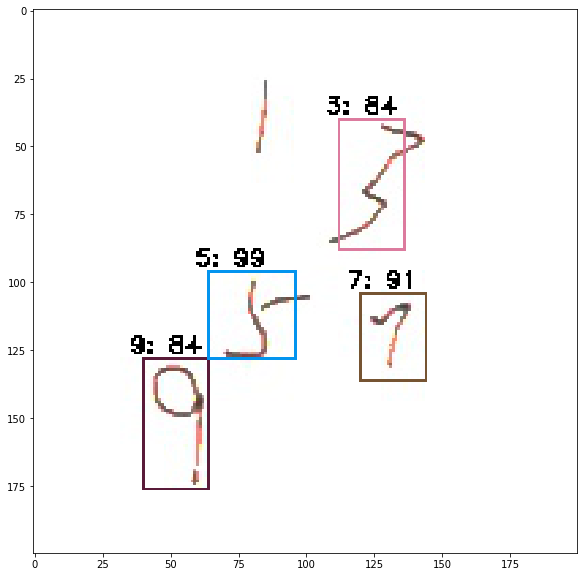

In [40]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join('show_img/temp', img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))
    #X, _, _, _, _ = next(data_gen_train)
    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)
    ##[Y1, Y2] = model_rpn.predict(X)
    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
        ##[P_cls, P_regr] = model_classifier.predict([X, ROIs])
        
        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []
    img = 255-img
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            if jk>5:
                break
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),1)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.3,1)
            textOrg = (real_x1, real_y1-0)
            #baseLine=5
            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] - 5, textOrg[1]-retval[1] - 5), (200, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] - 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, (textOrg[0] - 5, textOrg[1]+baseLine - 5), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    #plt.grid('off')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

In [48]:
image_data

{'filepath': 'train_image/train_image_2657.jpg',
 'width': 200,
 'height': 200,
 'bboxes': [{'class': '9', 'x1': 79, 'x2': 97, 'y1': 43, 'y2': 83},
  {'class': '7', 'x1': 39, 'x2': 62, 'y1': 74, 'y2': 111},
  {'class': '8', 'x1': 68, 'x2': 86, 'y1': 148, 'y2': 175},
  {'class': '7', 'x1': 109, 'x2': 128, 'y1': 20, 'y2': 59}]}

In [31]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))
    #漏检的计入
	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [32]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	#img[:, :, 0] -= C.img_channel_mean[0]
	#img[:, :, 1] -= C.img_channel_mean[1]
	#img[:, :, 2] -= C.img_channel_mean[2]
	img /= 255.0
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [33]:
print(class_mapping)

{0: '1', 1: '0', 2: '9', 3: '6', 4: '3', 5: '5', 6: '7', 7: '8', 8: '4', 9: '2', 10: 'bg'}


In [34]:
# This might takes a while to parser the data
#test_path = 'test_info.txt' # Test data (annotation file)

test_imgs, _, _ = get_data(test_path)

Parsing annotation files
idx=5039

In [35]:
len(test_imgs)

1000

In [40]:
T = {}
P = {}
mAPs = []
bbox_threshold = 0.7
for idx, img_data in enumerate(train_imgs):
    print('{}/{}'.format(idx,len(train_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []
    for key in bboxes:
        bbox = np.array(bboxes[key])
        
        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)
            
          # Calculate real coordinates on original image

#######
    print('Elapsed time = {}'.format(time.time() - st))
    #a = all_dets
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/3000
bboxes.shape[0]: 2
Elapsed time = 0.6002943515777588
6 AP: 1.0
0 AP: 0.5
1 AP: 0.3333333333333333
9 AP: 1.0
3 AP: 1.0
mAP = 0.7666666666666666
1/3000
bboxes.shape[0]: 2
Elapsed time = 0.3263084888458252
6 AP: 1.0
0 AP: 0.5
1 AP: 0.3333333333333333
9 AP: 1.0
3 AP: 1.0
7 AP: 1.0
5 AP: 1.0
mAP = 0.8333333333333333
2/3000
bboxes.shape[0]: 2
Elapsed time = 0.31423473358154297
6 AP: 1.0
0 AP: 0.5
1 AP: 0.4
9 AP: 1.0
3 AP: 1.0
7 AP: 1.0
5 AP: 1.0
4 AP: 1.0
8 AP: 1.0
2 AP: 1.0
mAP = 0.89
3/3000
bboxes.shape[0]: 2
Elapsed time = 0.3120918273925781
6 AP: 1.0
0 AP: 0.5
1 AP: 0.4
9 AP: 1.0
3 AP: 1.0
7 AP: 1.0
5 AP: 1.0
4 AP: 1.0
8 AP: 1.0
2 AP: 1.0
mAP = 0.89
4/3000
bboxes.shape[0]: 2
Elapsed time = 0.37009239196777344
6 AP: 1.0
0 AP: 0.5
1 AP: 0.4
9 AP: 1.0
3 AP: 1.0
7 AP: 1.0
5 AP: 1.0
4 AP: 1.0
8 AP: 1.0
2 AP: 1.0
mAP = 0.89
5/3000
bboxes.shape[0]: 2
Elapsed time = 0.35356950759887695
6 AP: 1.0
0 AP: 0.6666666666666666
1 AP: 0.42857142857142855
9 AP: 1.0
3 AP: 1.0
7 AP: 1.0
5 AP: 1.0
4 A

bboxes.shape[0]: 2
Elapsed time = 0.33262133598327637
6 AP: 0.8707039925527322
0 AP: 0.7817404817404817
1 AP: 0.6803751073487916
9 AP: 0.9679425837320572
3 AP: 0.9999999999999998
7 AP: 0.8919753086419755
5 AP: 1.0
4 AP: 1.0
8 AP: 1.0000000000000002
2 AP: 0.8238726916358495
mAP = 0.9016610165651887
34/3000
bboxes.shape[0]: 2
Elapsed time = 0.3284642696380615
6 AP: 0.8729327584414834
0 AP: 0.7954596990311277
1 AP: 0.6605494350850387
9 AP: 0.9653230065129377
3 AP: 0.9999999999999998
7 AP: 0.8919753086419755
5 AP: 1.0
4 AP: 1.0
8 AP: 1.0000000000000002
2 AP: 0.8238726916358495
mAP = 0.9010112899348413
35/3000
bboxes.shape[0]: 2
Elapsed time = 0.3323202133178711
6 AP: 0.8597865965714935
0 AP: 0.8175874472749474
1 AP: 0.6601402738128745
9 AP: 0.9653230065129377
3 AP: 0.9999999999999998
7 AP: 0.8919753086419755
5 AP: 1.0
4 AP: 0.9999999999999999
8 AP: 1.0000000000000002
2 AP: 0.8282475694240401
mAP = 0.9023060202238268
36/3000
bboxes.shape[0]: 2
Elapsed time = 0.33993029594421387
6 AP: 0.8630

bboxes.shape[0]: 2
Elapsed time = 0.32854700088500977
6 AP: 0.873836667291559
0 AP: 0.8680407313053506
1 AP: 0.6325325384882247
9 AP: 0.9805371599726439
3 AP: 1.0
7 AP: 0.9506833982845904
5 AP: 0.9914205955334987
4 AP: 1.0
8 AP: 0.9999999999999999
2 AP: 0.889418053535721
mAP = 0.9186469144411588
60/3000
bboxes.shape[0]: 2
Elapsed time = 0.29720568656921387
6 AP: 0.873836667291559
0 AP: 0.8680407313053506
1 AP: 0.6325325384882247
9 AP: 0.9805371599726439
3 AP: 0.9999999999999999
7 AP: 0.9506833982845904
5 AP: 0.9919588513338513
4 AP: 0.9999999999999999
8 AP: 1.0
2 AP: 0.889418053535721
mAP = 0.918700740021194
61/3000
bboxes.shape[0]: 2
Elapsed time = 0.35511159896850586
6 AP: 0.8764962664151148
0 AP: 0.8680407313053506
1 AP: 0.6343806068192491
9 AP: 0.9805371599726439
3 AP: 1.0
7 AP: 0.9423779755901368
5 AP: 0.9919588513338513
4 AP: 0.9999999999999999
8 AP: 1.0
2 AP: 0.889418053535721
mAP = 0.9183209644972067
62/3000
bboxes.shape[0]: 2
Elapsed time = 0.2945828437805176
6 AP: 0.876496266

bboxes.shape[0]: 2
Elapsed time = 0.3003368377685547
6 AP: 0.8762468534585706
0 AP: 0.8721697843711945
1 AP: 0.6448488887423721
9 AP: 0.9852358802078848
3 AP: 0.9879374337221632
7 AP: 0.954345731141254
5 AP: 0.9700488237730999
4 AP: 1.0
8 AP: 1.0000000000000002
2 AP: 0.8488396823622418
mAP = 0.913967307777878
87/3000
bboxes.shape[0]: 2
Elapsed time = 0.3126955032348633
6 AP: 0.8762468534585706
0 AP: 0.8721697843711945
1 AP: 0.6405953655945678
9 AP: 0.9853691355931278
3 AP: 0.9884874492432631
7 AP: 0.954345731141254
5 AP: 0.9700488237730999
4 AP: 1.0
8 AP: 1.0000000000000002
2 AP: 0.8488396823622418
mAP = 0.913610282553732
88/3000
bboxes.shape[0]: 2
Elapsed time = 0.30300021171569824
6 AP: 0.8695087519356623
0 AP: 0.8721697843711945
1 AP: 0.6405953655945678
9 AP: 0.985953097488099
3 AP: 0.9884874492432631
7 AP: 0.9567800843982586
5 AP: 0.9712234243366802
4 AP: 1.0
8 AP: 1.0000000000000002
2 AP: 0.8488396823622418
mAP = 0.9133557639729968
89/3000
bboxes.shape[0]: 2
Elapsed time = 0.31617

bboxes.shape[0]: 2
Elapsed time = 0.3260805606842041
6 AP: 0.8981735633000305
0 AP: 0.8861352283391275
1 AP: 0.640870970016961
9 AP: 0.9862700505307438
3 AP: 0.9898746535651299
7 AP: 0.9590042462589988
5 AP: 0.9540698113093955
4 AP: 1.0
8 AP: 1.0
2 AP: 0.8798664058122194
mAP = 0.9194264929132606
113/3000
bboxes.shape[0]: 2
Elapsed time = 0.3436455726623535
6 AP: 0.8981735633000305
0 AP: 0.8834571416610879
1 AP: 0.640870970016961
9 AP: 0.9862700505307438
3 AP: 0.9898746535651299
7 AP: 0.9590042462589988
5 AP: 0.9540698113093955
4 AP: 1.0
8 AP: 1.0
2 AP: 0.8798664058122194
mAP = 0.9191586842454565
114/3000
bboxes.shape[0]: 2
Elapsed time = 0.3005027770996094
6 AP: 0.9010866352253767
0 AP: 0.8834571416610879
1 AP: 0.6476043078838258
9 AP: 0.9862700505307438
3 AP: 0.9902915451895046
7 AP: 0.9590042462589988
5 AP: 0.9540698113093955
4 AP: 1.0
8 AP: 1.0
2 AP: 0.8816485701276248
mAP = 0.9203432308186559
115/3000
bboxes.shape[0]: 2
Elapsed time = 0.3018782138824463
6 AP: 0.9011229843534765
0 A

bboxes.shape[0]: 2
Elapsed time = 0.3482856750488281
6 AP: 0.9111953703199336
0 AP: 0.8607062707349487
1 AP: 0.6488703324637924
9 AP: 0.9673249080499444
3 AP: 0.9815713056269287
7 AP: 0.9656773419364904
5 AP: 0.910992853318344
4 AP: 0.9999999999999998
8 AP: 0.9936905404931216
2 AP: 0.8878996888545287
mAP = 0.9127928611798032
139/3000
bboxes.shape[0]: 2
Elapsed time = 0.33193445205688477
6 AP: 0.9111953703199336
0 AP: 0.861028338365402
1 AP: 0.6488703324637924
9 AP: 0.9677759008729064
3 AP: 0.9816620360793389
7 AP: 0.9656773419364904
5 AP: 0.911836755978046
4 AP: 0.9999999999999998
8 AP: 0.9936905404931216
2 AP: 0.8878996888545287
mAP = 0.912963630536356
140/3000
bboxes.shape[0]: 2
Elapsed time = 0.3254694938659668
6 AP: 0.9148817421485945
0 AP: 0.861028338365402
1 AP: 0.653946942680169
9 AP: 0.9677759008729064
3 AP: 0.9816620360793389
7 AP: 0.9654736471229212
5 AP: 0.911836755978046
4 AP: 1.0
8 AP: 0.9936905404931216
2 AP: 0.8878996888545287
mAP = 0.9138195592595026
141/3000
bboxes.sha

bboxes.shape[0]: 2
Elapsed time = 0.3533165454864502
6 AP: 0.9310963970461965
0 AP: 0.8761633414162616
1 AP: 0.682711700955647
9 AP: 0.9653622266976167
3 AP: 0.9743071337314575
7 AP: 0.9680976482064128
5 AP: 0.9103854375192716
4 AP: 1.0000000000000002
8 AP: 0.9946995408989443
2 AP: 0.8915004366942623
mAP = 0.919432386316607
164/3000
bboxes.shape[0]: 2
Elapsed time = 0.3281998634338379
6 AP: 0.933379495659816
0 AP: 0.8761633414162616
1 AP: 0.682711700955647
9 AP: 0.9653622266976167
3 AP: 0.9743071337314575
7 AP: 0.9689462424010216
5 AP: 0.9103854375192716
4 AP: 0.9999999999999998
8 AP: 0.9946995408989443
2 AP: 0.8915004366942623
mAP = 0.9197455555974298
165/3000
bboxes.shape[0]: 2
Elapsed time = 0.3356161117553711
6 AP: 0.9355212640561099
0 AP: 0.8761633414162616
1 AP: 0.682711700955647
9 AP: 0.9658343077747747
3 AP: 0.9743071337314575
7 AP: 0.9697608728003249
5 AP: 0.91207328218853
4 AP: 0.9999999999999998
8 AP: 0.9948359384754406
2 AP: 0.8915004366942623
mAP = 0.9202708278092807
166/3

bboxes.shape[0]: 2
Elapsed time = 0.35727667808532715
6 AP: 0.8804689618052871
0 AP: 0.88557161767539
1 AP: 0.6820863006947083
9 AP: 0.9674675975933837
3 AP: 0.9806652791368684
7 AP: 0.9705756814352559
5 AP: 0.9235212922131084
4 AP: 0.9999999999999999
8 AP: 0.9953358326107792
2 AP: 0.9048376144543157
mAP = 0.9190530177619097
190/3000
bboxes.shape[0]: 2
Elapsed time = 0.31668567657470703
6 AP: 0.8804689618052871
0 AP: 0.8836239842198033
1 AP: 0.6820863006947083
9 AP: 0.9682681863755673
3 AP: 0.9811154781775644
7 AP: 0.9695571214511787
5 AP: 0.9235212922131084
4 AP: 0.9999999999999999
8 AP: 0.9952636665541671
2 AP: 0.9048376144543157
mAP = 0.91887426059457
191/3000
bboxes.shape[0]: 2
Elapsed time = 0.3397808074951172
6 AP: 0.8810598109165753
0 AP: 0.8818150783045109
1 AP: 0.683587757197498
9 AP: 0.9660186214471116
3 AP: 0.9811154781775644
7 AP: 0.9695571214511787
5 AP: 0.9235212922131084
4 AP: 0.9999999999999999
8 AP: 0.9952636665541671
2 AP: 0.9063809517611404
mAP = 0.9188319778022855
1

bboxes.shape[0]: 2
Elapsed time = 0.40889883041381836
6 AP: 0.878494418355159
0 AP: 0.852569580352459
1 AP: 0.68164493665139
9 AP: 0.9683248258629764
3 AP: 0.9744447112515036
7 AP: 0.9666069556763752
5 AP: 0.9273151219912146
4 AP: 1.0
8 AP: 0.9952788205092187
2 AP: 0.9175033813732164
mAP = 0.9162182752023511
215/3000
bboxes.shape[0]: 2
Elapsed time = 0.3116896152496338
6 AP: 0.8786931673941496
0 AP: 0.8542157563897648
1 AP: 0.68164493665139
9 AP: 0.9686873491585362
3 AP: 0.9744447112515036
7 AP: 0.9666069556763752
5 AP: 0.9274302455932688
4 AP: 0.9999999999999998
8 AP: 0.9952673884502377
2 AP: 0.9175033813732164
mAP = 0.9164493891938441
216/3000
bboxes.shape[0]: 2
Elapsed time = 0.32476115226745605
6 AP: 0.8786931673941496
0 AP: 0.8542157563897648
1 AP: 0.68164493665139
9 AP: 0.9686873491585362
3 AP: 0.9744967829222033
7 AP: 0.9679701314244258
5 AP: 0.9280058850825788
4 AP: 0.9999999999999998
8 AP: 0.9952673884502377
2 AP: 0.9191155855624011
mAP = 0.9168096983035687
217/3000
bboxes.sha

bboxes.shape[0]: 2
Elapsed time = 0.33173608779907227
6 AP: 0.8715502027853343
0 AP: 0.8663476848321341
1 AP: 0.6736692247309901
9 AP: 0.963515041406505
3 AP: 0.9657064255497463
7 AP: 0.9686314405449066
5 AP: 0.932549083242445
4 AP: 0.9921339858810115
8 AP: 0.9953794675506672
2 AP: 0.9203131426557308
mAP = 0.914979569917947
240/3000
bboxes.shape[0]: 2
Elapsed time = 0.3131239414215088
6 AP: 0.8715502027853343
0 AP: 0.8684567163022512
1 AP: 0.6688911756685423
9 AP: 0.963515041406505
3 AP: 0.9657064255497463
7 AP: 0.9684493080932923
5 AP: 0.9326754239535481
4 AP: 0.9922763400805825
8 AP: 0.9953794675506672
2 AP: 0.9203131426557308
mAP = 0.9147213244046201
241/3000
bboxes.shape[0]: 2
Elapsed time = 0.30815982818603516
6 AP: 0.8715502027853343
0 AP: 0.8684567163022512
1 AP: 0.6688911756685423
9 AP: 0.9639297180996895
3 AP: 0.9657064255497463
7 AP: 0.9692054234407282
5 AP: 0.9331646700151621
4 AP: 0.9924147742308821
8 AP: 0.9953718063705342
2 AP: 0.9203131426557308
mAP = 0.9149004055118601


bboxes.shape[0]: 2
Elapsed time = 0.308549165725708
6 AP: 0.8731774767632031
0 AP: 0.8785691713967803
1 AP: 0.6687253218528425
9 AP: 0.9656393471629957
3 AP: 0.9681514590546066
7 AP: 0.9630628246655901
5 AP: 0.9386535219448694
4 AP: 0.9934706645809849
8 AP: 0.9956808749652504
2 AP: 0.9245609865848357
mAP = 0.9169691648971959
265/3000
bboxes.shape[0]: 2
Elapsed time = 0.31279850006103516
6 AP: 0.8733320485280122
0 AP: 0.8795229697584278
1 AP: 0.6687253218528425
9 AP: 0.9659987371206122
3 AP: 0.9687248799145455
7 AP: 0.9630628246655901
5 AP: 0.9386535219448694
4 AP: 0.9934706645809849
8 AP: 0.9956808749652504
2 AP: 0.924989295887575
mAP = 0.9172161139218709
266/3000
bboxes.shape[0]: 2
Elapsed time = 0.30819177627563477
6 AP: 0.8733320485280122
0 AP: 0.8795229697584278
1 AP: 0.671717480946038
9 AP: 0.9665791668438597
3 AP: 0.9687248799145455
7 AP: 0.9630628246655901
5 AP: 0.9385796543113177
4 AP: 0.9934706645809849
8 AP: 0.9956808749652504
2 AP: 0.9219926415938102
mAP = 0.9172663206107836

bboxes.shape[0]: 2
Elapsed time = 0.29660940170288086
6 AP: 0.8611692263157775
0 AP: 0.866354607149822
1 AP: 0.671571553737936
9 AP: 0.9694574410249939
3 AP: 0.9602939349882679
7 AP: 0.9628201696500128
5 AP: 0.9418918298631627
4 AP: 0.994249521165441
8 AP: 0.995723133471318
2 AP: 0.9075809831594525
mAP = 0.9131112400526182
290/3000
bboxes.shape[0]: 2
Elapsed time = 0.34452128410339355
6 AP: 0.8611692263157775
0 AP: 0.8675569597015585
1 AP: 0.671571553737936
9 AP: 0.9697475575171375
3 AP: 0.9602939349882679
7 AP: 0.9628201696500128
5 AP: 0.9425629058474863
4 AP: 0.9942568591755212
8 AP: 0.9957206524352997
2 AP: 0.9075809831594525
mAP = 0.9133280802528448
291/3000
bboxes.shape[0]: 2
Elapsed time = 0.3062140941619873
6 AP: 0.859504820261696
0 AP: 0.8675569597015585
1 AP: 0.671571553737936
9 AP: 0.9697475575171375
3 AP: 0.960950171683815
7 AP: 0.9629935664875415
5 AP: 0.9425629058474863
4 AP: 0.9944937961550887
8 AP: 0.9957206524352997
2 AP: 0.9075809831594525
mAP = 0.913268296698701
292/3

bboxes.shape[0]: 2
Elapsed time = 0.30301594734191895
6 AP: 0.8592193970878221
0 AP: 0.8695100181694624
1 AP: 0.6887753194488706
9 AP: 0.9542098386273873
3 AP: 0.9629652214788297
7 AP: 0.9641672795346816
5 AP: 0.9420161517773122
4 AP: 0.9950920973144655
8 AP: 0.9959629952439731
2 AP: 0.9104795293920189
mAP = 0.9142397848074824
315/3000
bboxes.shape[0]: 2
Elapsed time = 0.29412198066711426
6 AP: 0.8592193970878221
0 AP: 0.8698454628195984
1 AP: 0.6809411030757668
9 AP: 0.9542098386273873
3 AP: 0.9629652214788297
7 AP: 0.9652647697495658
5 AP: 0.9423861856045529
4 AP: 0.9950920973144655
8 AP: 0.9959629952439731
2 AP: 0.9104795293920189
mAP = 0.913636660039398
316/3000
bboxes.shape[0]: 2
Elapsed time = 0.30623722076416016
6 AP: 0.8592193970878221
0 AP: 0.8618284284968973
1 AP: 0.6809411030757668
9 AP: 0.9542098386273873
3 AP: 0.9629652214788297
7 AP: 0.9652647697495658
5 AP: 0.9423932325174031
4 AP: 0.9950920973144655
8 AP: 0.9959629952439731
2 AP: 0.9111984688103159
mAP = 0.9129075552402

bboxes.shape[0]: 2
Elapsed time = 0.3092505931854248
6 AP: 0.8559202930793336
0 AP: 0.8622231797868541
1 AP: 0.684126009534035
9 AP: 0.9575333848360423
3 AP: 0.95921976185439
7 AP: 0.9654999596291335
5 AP: 0.938990825517616
4 AP: 0.9914743835364441
8 AP: 0.9962426512830898
2 AP: 0.8897103281259594
mAP = 0.9100940777182898
340/3000
bboxes.shape[0]: 2
Elapsed time = 0.3121376037597656
6 AP: 0.8559202930793336
0 AP: 0.8622231797868541
1 AP: 0.684126009534035
9 AP: 0.957619380277935
3 AP: 0.9598285975059858
7 AP: 0.9654999596291335
5 AP: 0.9322414765250077
4 AP: 0.9914743835364441
8 AP: 0.9962426512830898
2 AP: 0.8897103281259594
mAP = 0.9094886259283779
341/3000
bboxes.shape[0]: 2
Elapsed time = 0.3079817295074463
6 AP: 0.8535477637650349
0 AP: 0.8622231797868541
1 AP: 0.6847581031499732
9 AP: 0.9577788062292131
3 AP: 0.9604228447934919
7 AP: 0.9654999596291335
5 AP: 0.9322414765250077
4 AP: 0.9914743835364441
8 AP: 0.9962426512830898
2 AP: 0.8908439533052313
mAP = 0.9095033122003473
342/

bboxes.shape[0]: 2
Elapsed time = 0.29677796363830566
6 AP: 0.8480607591584035
0 AP: 0.8444981052774819
1 AP: 0.6934696009120837
9 AP: 0.9569218359535685
3 AP: 0.9540121314054983
7 AP: 0.9666262890935138
5 AP: 0.9374041580009835
4 AP: 0.9917649488402895
8 AP: 0.9967258954819305
2 AP: 0.8907220093127666
mAP = 0.9080205733436519
365/3000
bboxes.shape[0]: 2
Elapsed time = 0.29712557792663574
6 AP: 0.8480607591584035
0 AP: 0.8444981052774819
1 AP: 0.6934696009120837
9 AP: 0.9573375644031876
3 AP: 0.95401108430887
7 AP: 0.9670729580485741
5 AP: 0.9385682301395348
4 AP: 0.9917649488402895
8 AP: 0.9967240515064597
2 AP: 0.8907220093127666
mAP = 0.9082229311907651
366/3000
bboxes.shape[0]: 2
Elapsed time = 0.2963378429412842
6 AP: 0.8480607591584035
0 AP: 0.8453583069415685
1 AP: 0.6927727713450487
9 AP: 0.9570494357951007
3 AP: 0.9540735392441281
7 AP: 0.9670729580485741
5 AP: 0.9385682301395348
4 AP: 0.9917649488402895
8 AP: 0.9967240515064597
2 AP: 0.8907220093127666
mAP = 0.908216701033187

bboxes.shape[0]: 2
Elapsed time = 0.29332494735717773
6 AP: 0.8577255824061947
0 AP: 0.8447975743579641
1 AP: 0.687455690317027
9 AP: 0.9589625645307331
3 AP: 0.9500769368140466
7 AP: 0.9676689815110143
5 AP: 0.9407638923202977
4 AP: 0.9925751029233987
8 AP: 0.9968305152584362
2 AP: 0.896849762425711
mAP = 0.9093706602864824
390/3000
bboxes.shape[0]: 2
Elapsed time = 0.29697704315185547
6 AP: 0.8577255824061947
0 AP: 0.8447975743579641
1 AP: 0.6858941210474014
9 AP: 0.9589625645307331
3 AP: 0.9500769368140466
7 AP: 0.9680681140894768
5 AP: 0.9348177285215118
4 AP: 0.9925404044043311
8 AP: 0.9968305152584362
2 AP: 0.896849762425711
mAP = 0.9086563303855808
391/3000
bboxes.shape[0]: 2
Elapsed time = 0.29639220237731934
6 AP: 0.8577255824061947
0 AP: 0.8404811126873095
1 AP: 0.685971003003763
9 AP: 0.9589625645307331
3 AP: 0.9500769368140466
7 AP: 0.9682176563406617
5 AP: 0.9348177285215118
4 AP: 0.9925404044043311
8 AP: 0.9968305152584362
2 AP: 0.8968301526073146
mAP = 0.9082453656574303

bboxes.shape[0]: 2
Elapsed time = 0.2935624122619629
6 AP: 0.8570928033048276
0 AP: 0.8456606788535299
1 AP: 0.669768976803804
9 AP: 0.9588764673781941
3 AP: 0.9443913410101133
7 AP: 0.9681653850272529
5 AP: 0.936845253902435
4 AP: 0.9930793562495422
8 AP: 0.9928970328539906
2 AP: 0.8990949781840585
mAP = 0.9065872273567747
415/3000
bboxes.shape[0]: 2
Elapsed time = 0.31258368492126465
6 AP: 0.8573133279989968
0 AP: 0.8473512605672459
1 AP: 0.669768976803804
9 AP: 0.9593830267154335
3 AP: 0.9443913410101133
7 AP: 0.9681653850272529
5 AP: 0.936845253902435
4 AP: 0.9930793562495422
8 AP: 0.9928970328539906
2 AP: 0.8980341772850167
mAP = 0.9067229138413829
416/3000
bboxes.shape[0]: 2
Elapsed time = 0.3132932186126709
6 AP: 0.8577298686306705
0 AP: 0.8473512605672459
1 AP: 0.6696715428927185
9 AP: 0.9593830267154335
3 AP: 0.9443913410101133
7 AP: 0.9681667396596556
5 AP: 0.936845253902435
4 AP: 0.9930793562495422
8 AP: 0.9928970328539906
2 AP: 0.8978819902142186
mAP = 0.9067397412696023
41

bboxes.shape[0]: 2
Elapsed time = 0.3127098083496094
6 AP: 0.8524642132149394
0 AP: 0.8473947084206612
1 AP: 0.6772424589782244
9 AP: 0.9576713159591663
3 AP: 0.9451527513011171
7 AP: 0.9689328991268854
5 AP: 0.9382487205333603
4 AP: 0.9913769485237915
8 AP: 0.9933080574838209
2 AP: 0.9004317389291367
mAP = 0.9072223812471105
440/3000
bboxes.shape[0]: 2
Elapsed time = 0.31298065185546875
6 AP: 0.8524642132149394
0 AP: 0.8473947084206612
1 AP: 0.6773457906998411
9 AP: 0.9575737734233571
3 AP: 0.9452000619739993
7 AP: 0.9689328991268854
5 AP: 0.9388499640623014
4 AP: 0.9913769485237915
8 AP: 0.9933304315405307
2 AP: 0.9004317389291367
mAP = 0.9072900529915444
441/3000
bboxes.shape[0]: 2
Elapsed time = 0.2969481945037842
6 AP: 0.8524642132149394
0 AP: 0.8473947084206612
1 AP: 0.6782601029723375
9 AP: 0.9575737734233571
3 AP: 0.9458433749093877
7 AP: 0.9689328991268854
5 AP: 0.9392749551168063
4 AP: 0.9913769485237915
8 AP: 0.9933304315405307
2 AP: 0.8988741642921986
mAP = 0.90733255715408

bboxes.shape[0]: 2
Elapsed time = 0.31938910484313965
6 AP: 0.8599744574373931
0 AP: 0.8470522859792678
1 AP: 0.678696178508036
9 AP: 0.9584922176457591
3 AP: 0.9459849066523478
7 AP: 0.9647065750576549
5 AP: 0.9401825972751159
4 AP: 0.9918719318070104
8 AP: 0.9935428405504821
2 AP: 0.8990583101044166
mAP = 0.9079562301017484
465/3000
bboxes.shape[0]: 2
Elapsed time = 0.312791109085083
6 AP: 0.8599744574373931
0 AP: 0.8470522859792678
1 AP: 0.678696178508036
9 AP: 0.9579480902403179
3 AP: 0.9459849066523478
7 AP: 0.9648567321384484
5 AP: 0.9402389939733967
4 AP: 0.9919837244581888
8 AP: 0.9936317762130931
2 AP: 0.8990583101044166
mAP = 0.9079425455704907
466/3000
bboxes.shape[0]: 2
Elapsed time = 0.3647277355194092
6 AP: 0.8615546126006732
0 AP: 0.847801421315133
1 AP: 0.678696178508036
9 AP: 0.9579480902403179
3 AP: 0.9465485938157434
7 AP: 0.965208858336355
5 AP: 0.9402389939733967
4 AP: 0.9919837244581888
8 AP: 0.9936317762130931
2 AP: 0.8990583101044166
mAP = 0.9082670559565355
467

bboxes.shape[0]: 2
Elapsed time = 0.3297252655029297
6 AP: 0.872024943648851
0 AP: 0.8462752340183877
1 AP: 0.6892713197636284
9 AP: 0.9581169979182106
3 AP: 0.9436976814839635
7 AP: 0.9677161515253349
5 AP: 0.9425183641784278
4 AP: 0.9869259326502481
8 AP: 0.9940566694861912
2 AP: 0.9019432935861909
mAP = 0.9102546588259435
490/3000
bboxes.shape[0]: 2
Elapsed time = 0.3081698417663574
6 AP: 0.872024943648851
0 AP: 0.8462752340183877
1 AP: 0.6892713197636284
9 AP: 0.9582166857542569
3 AP: 0.9436976814839635
7 AP: 0.9677161515253349
5 AP: 0.9425183641784278
4 AP: 0.9869259326502481
8 AP: 0.9941146599908746
2 AP: 0.9021311493427759
mAP = 0.9102892122356747
491/3000
bboxes.shape[0]: 2
Elapsed time = 0.3091621398925781
6 AP: 0.872024943648851
0 AP: 0.8467816770288659
1 AP: 0.6892713197636284
9 AP: 0.9582166857542569
3 AP: 0.9436976814839635
7 AP: 0.9680246955330694
5 AP: 0.9425183641784278
4 AP: 0.9869259326502481
8 AP: 0.9941146599908746
2 AP: 0.903884482648019
mAP = 0.9105460442680204
49

bboxes.shape[0]: 2
Elapsed time = 0.30898571014404297
6 AP: 0.8729162749102639
0 AP: 0.8466545309578183
1 AP: 0.678821321241611
9 AP: 0.9594737416192367
3 AP: 0.946246432960124
7 AP: 0.9682100360229363
5 AP: 0.9460087166164122
4 AP: 0.9853327670374519
8 AP: 0.9872385639518402
2 AP: 0.9071972609147221
mAP = 0.9098099646232416
515/3000
bboxes.shape[0]: 2
Elapsed time = 0.2938241958618164
6 AP: 0.8729162749102639
0 AP: 0.8466545309578183
1 AP: 0.678821321241611
9 AP: 0.9561804217729861
3 AP: 0.946246432960124
7 AP: 0.9682100360229363
5 AP: 0.9466803205222656
4 AP: 0.9853327670374519
8 AP: 0.9872592840834058
2 AP: 0.9079557360862999
mAP = 0.9096257125595164
516/3000
bboxes.shape[0]: 2
Elapsed time = 0.29648447036743164
6 AP: 0.8729162749102639
0 AP: 0.8466545309578183
1 AP: 0.6801674392238052
9 AP: 0.9561804217729861
3 AP: 0.9465883378457752
7 AP: 0.9665491389272598
5 AP: 0.9466803205222656
4 AP: 0.9853327670374519
8 AP: 0.9872566202921805
2 AP: 0.9079557360862999
mAP = 0.9096281587576106


bboxes.shape[0]: 2
Elapsed time = 0.33118271827697754
6 AP: 0.8740773799729258
0 AP: 0.8498132333843352
1 AP: 0.688048929317225
9 AP: 0.953221784026367
3 AP: 0.9478265311108871
7 AP: 0.9683467417300243
5 AP: 0.9507534215218574
4 AP: 0.9859857360542278
8 AP: 0.9876752251221553
2 AP: 0.8959429092468142
mAP = 0.910169189148682
540/3000
bboxes.shape[0]: 2
Elapsed time = 0.3419370651245117
6 AP: 0.8740773799729258
0 AP: 0.8498132333843352
1 AP: 0.6885543584742482
9 AP: 0.953493156245587
3 AP: 0.9478265311108871
7 AP: 0.9676197193976461
5 AP: 0.9507534215218574
4 AP: 0.9859857360542278
8 AP: 0.9876752251221553
2 AP: 0.8969820187994347
mAP = 0.9102780780083304
541/3000
bboxes.shape[0]: 2
Elapsed time = 0.3159983158111572
6 AP: 0.875186428271256
0 AP: 0.8498132333843352
1 AP: 0.6887624700567331
9 AP: 0.953493156245587
3 AP: 0.9478562627361545
7 AP: 0.9678875585347215
5 AP: 0.9507853805034139
4 AP: 0.9859857360542278
8 AP: 0.9876752251221553
2 AP: 0.8974925934096618
mAP = 0.9104938044318246
542

bboxes.shape[0]: 2
Elapsed time = 0.3241920471191406
6 AP: 0.865394945513096
0 AP: 0.8466474903566397
1 AP: 0.691967547714379
9 AP: 0.9528194082399042
3 AP: 0.9479732257876434
7 AP: 0.9684778783291681
5 AP: 0.9479853661844858
4 AP: 0.9868854376295966
8 AP: 0.9878918158480342
2 AP: 0.9015156084553394
mAP = 0.9097558724058287
565/3000
bboxes.shape[0]: 2
Elapsed time = 0.30721116065979004
6 AP: 0.8667760426103186
0 AP: 0.8479163587181365
1 AP: 0.691967547714379
9 AP: 0.9528194082399042
3 AP: 0.9479732257876434
7 AP: 0.9684778783291681
5 AP: 0.9479853661844858
4 AP: 0.9868854376295966
8 AP: 0.9878918158480342
2 AP: 0.9018599513608396
mAP = 0.9100553032422505
566/3000
bboxes.shape[0]: 2
Elapsed time = 0.33559679985046387
6 AP: 0.8667760426103186
0 AP: 0.8479163587181365
1 AP: 0.6914155562616963
9 AP: 0.9528194082399042
3 AP: 0.9480010543190638
7 AP: 0.9684778783291681
5 AP: 0.9481378563849066
4 AP: 0.9870161451493418
8 AP: 0.9878918158480342
2 AP: 0.9022015078948817
mAP = 0.9100653623755453

bboxes.shape[0]: 2
Elapsed time = 0.3208186626434326
6 AP: 0.8669368320977736
0 AP: 0.8521486420503737
1 AP: 0.6931590837337971
9 AP: 0.9487877473607339
3 AP: 0.9480248110931689
7 AP: 0.9668500219430044
5 AP: 0.9488015828909319
4 AP: 0.9871525560679033
8 AP: 0.9884208211414311
2 AP: 0.8991828713969365
mAP = 0.9099464969776054
590/3000
bboxes.shape[0]: 2
Elapsed time = 0.3369600772857666
6 AP: 0.8669368320977736
0 AP: 0.8530628232333055
1 AP: 0.6931590837337971
9 AP: 0.9483236792416778
3 AP: 0.9480248110931689
7 AP: 0.9673095247543683
5 AP: 0.9488015828909319
4 AP: 0.9871456192945867
8 AP: 0.9884208211414311
2 AP: 0.8991828713969365
mAP = 0.9100367648877977
591/3000
bboxes.shape[0]: 2
Elapsed time = 0.3190627098083496
6 AP: 0.8669368320977736
0 AP: 0.8543713653816878
1 AP: 0.6931590837337971
9 AP: 0.9483236792416778
3 AP: 0.9480248110931689
7 AP: 0.9677591631006709
5 AP: 0.9488281838788066
4 AP: 0.9871456192945867
8 AP: 0.9884208211414311
2 AP: 0.8991828713969365
mAP = 0.910215243036053

bboxes.shape[0]: 2
Elapsed time = 0.33056068420410156
6 AP: 0.8747386348247903
0 AP: 0.8499585690639692
1 AP: 0.6981836163808812
9 AP: 0.9455160231912241
3 AP: 0.9458673941032486
7 AP: 0.9675245384958961
5 AP: 0.9506202386951248
4 AP: 0.9853138183667505
8 AP: 0.9889495849414838
2 AP: 0.8989643490488511
mAP = 0.910563676711222
615/3000
bboxes.shape[0]: 2
Elapsed time = 0.29677915573120117
6 AP: 0.8747386348247903
0 AP: 0.8499585690639692
1 AP: 0.6987074927216306
9 AP: 0.9455160231912241
3 AP: 0.9444170667692542
7 AP: 0.9675245384958961
5 AP: 0.9506202386951248
4 AP: 0.9853501479596551
8 AP: 0.9890119716352983
2 AP: 0.8989643490488511
mAP = 0.9104809032405694
616/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124275207519531
6 AP: 0.8747386348247903
0 AP: 0.8499585690639692
1 AP: 0.6967306844309684
9 AP: 0.9458708384760415
3 AP: 0.9444170667692542
7 AP: 0.9675245384958961
5 AP: 0.9506202386951248
4 AP: 0.9853501479596551
8 AP: 0.9890119716352983
2 AP: 0.8989643490488511
mAP = 0.91031870393998

bboxes.shape[0]: 2
Elapsed time = 0.3415217399597168
6 AP: 0.8768410249654308
0 AP: 0.8477032242987159
1 AP: 0.6983067709181767
9 AP: 0.9457481276303213
3 AP: 0.9448049493699177
7 AP: 0.9650279630420102
5 AP: 0.9523352093362091
4 AP: 0.985832940693082
8 AP: 0.9892337677093028
2 AP: 0.9003799523755992
mAP = 0.9106213930338767
640/3000
bboxes.shape[0]: 2
Elapsed time = 0.301694393157959
6 AP: 0.8768410249654308
0 AP: 0.8485187861633656
1 AP: 0.6983067709181767
9 AP: 0.9457481276303213
3 AP: 0.9448049493699177
7 AP: 0.9652580063835544
5 AP: 0.9523352093362091
4 AP: 0.985832940693082
8 AP: 0.9892784355850581
2 AP: 0.9003799523755992
mAP = 0.9107304203420716
641/3000
bboxes.shape[0]: 2
Elapsed time = 0.3184084892272949
6 AP: 0.877550528711846
0 AP: 0.8485187861633656
1 AP: 0.6963979509997755
9 AP: 0.9457481276303213
3 AP: 0.9448828441858055
7 AP: 0.9656362937391081
5 AP: 0.9523352093362091
4 AP: 0.985832940693082
8 AP: 0.9892784355850581
2 AP: 0.9003799523755992
mAP = 0.910656106942017
642/

bboxes.shape[0]: 2
Elapsed time = 0.33195996284484863
6 AP: 0.8752100402280457
0 AP: 0.8509238427023916
1 AP: 0.7029874771490277
9 AP: 0.9457250050081503
3 AP: 0.9471594997328715
7 AP: 0.9665281549436198
5 AP: 0.95158344282197
4 AP: 0.9836774317743626
8 AP: 0.9898224582771368
2 AP: 0.8888076998782788
mAP = 0.9102425052515855
665/3000
bboxes.shape[0]: 2
Elapsed time = 0.3497295379638672
6 AP: 0.8752100402280457
0 AP: 0.8511611605562334
1 AP: 0.7025559812090474
9 AP: 0.9457250050081503
3 AP: 0.9471594997328715
7 AP: 0.9666691742038123
5 AP: 0.95158344282197
4 AP: 0.9836954519713482
8 AP: 0.9898224582771368
2 AP: 0.8888076998782788
mAP = 0.9102389913886896
666/3000
bboxes.shape[0]: 2
Elapsed time = 0.30029726028442383
6 AP: 0.8760607312338015
0 AP: 0.8454797466044544
1 AP: 0.7025559812090474
9 AP: 0.9457250050081503
3 AP: 0.9471502343796664
7 AP: 0.9666691742038123
5 AP: 0.9517050330271024
4 AP: 0.9836954519713482
8 AP: 0.9898224582771368
2 AP: 0.8889370464750193
mAP = 0.909780086238954
6

bboxes.shape[0]: 2
Elapsed time = 0.2969083786010742
6 AP: 0.8783961451683808
0 AP: 0.8440287357558739
1 AP: 0.7035561702319535
9 AP: 0.9406622572032959
3 AP: 0.9477841801245819
7 AP: 0.9671687995500368
5 AP: 0.9528339638999962
4 AP: 0.9840085771984217
8 AP: 0.9901837476597548
2 AP: 0.8819831139766651
mAP = 0.909060569076896
690/3000
bboxes.shape[0]: 2
Elapsed time = 0.30245041847229004
6 AP: 0.8793965842369238
0 AP: 0.8440287357558739
1 AP: 0.7035561702319535
9 AP: 0.9408469853299468
3 AP: 0.9477841801245819
7 AP: 0.9671687995500368
5 AP: 0.9528339638999962
4 AP: 0.9840262171196985
8 AP: 0.9901828472900045
2 AP: 0.8823189623589324
mAP = 0.9092143445897948
691/3000
bboxes.shape[0]: 2
Elapsed time = 0.31053900718688965
6 AP: 0.8797422928066039
0 AP: 0.8446401988114942
1 AP: 0.7035561702319535
9 AP: 0.9408469853299468
3 AP: 0.9477841801245819
7 AP: 0.9671687995500368
5 AP: 0.9528339638999962
4 AP: 0.9840262171196985
8 AP: 0.990221068463355
2 AP: 0.8826205172570492
mAP = 0.909344039359471

bboxes.shape[0]: 2
Elapsed time = 0.31017446517944336
6 AP: 0.8844137005118016
0 AP: 0.8471743358722793
1 AP: 0.6974709900868379
9 AP: 0.9403689759916014
3 AP: 0.949489201497554
7 AP: 0.9685831608959499
5 AP: 0.954960927858689
4 AP: 0.983202241578558
8 AP: 0.9903976700060342
2 AP: 0.8850646911538824
mAP = 0.9101125895453187
715/3000
bboxes.shape[0]: 2
Elapsed time = 0.30898571014404297
6 AP: 0.8844137005118016
0 AP: 0.8463528049828162
1 AP: 0.6981738687491005
9 AP: 0.9403689759916014
3 AP: 0.949489201497554
7 AP: 0.9687709794010988
5 AP: 0.954960927858689
4 AP: 0.9832167388089126
8 AP: 0.9903976700060342
2 AP: 0.8854096397767595
mAP = 0.9101554507584367
716/3000
bboxes.shape[0]: 2
Elapsed time = 0.304532527923584
6 AP: 0.8853233761907617
0 AP: 0.8463528049828162
1 AP: 0.6981738687491005
9 AP: 0.9403689759916014
3 AP: 0.949501783817069
7 AP: 0.9682792368875724
5 AP: 0.954960927858689
4 AP: 0.9832167388089126
8 AP: 0.9903976700060342
2 AP: 0.885452671644558
mAP = 0.9102028054937115
717/3

bboxes.shape[0]: 2
Elapsed time = 0.3245198726654053
6 AP: 0.8860202216737845
0 AP: 0.8428534414155322
1 AP: 0.7034116863135575
9 AP: 0.9418277580808284
3 AP: 0.9460958214094506
7 AP: 0.9689909304476926
5 AP: 0.9567784029375941
4 AP: 0.9837665809595744
8 AP: 0.9906862208979783
2 AP: 0.8824728776358879
mAP = 0.9102903941771879
740/3000
bboxes.shape[0]: 2
Elapsed time = 0.31408166885375977
6 AP: 0.8860202216737845
0 AP: 0.8428685585381975
1 AP: 0.7035378217157537
9 AP: 0.9420768443452818
3 AP: 0.9464266315852827
7 AP: 0.9689909304476926
5 AP: 0.9567784029375941
4 AP: 0.9837665809595744
8 AP: 0.9906862208979783
2 AP: 0.8816514796022858
mAP = 0.9102803692703425
741/3000
bboxes.shape[0]: 2
Elapsed time = 0.31228160858154297
6 AP: 0.8863301082229795
0 AP: 0.8428685585381975
1 AP: 0.7035378217157537
9 AP: 0.9420768443452818
3 AP: 0.9444569276614025
7 AP: 0.9689909304476926
5 AP: 0.9571400795624733
4 AP: 0.9837665809595744
8 AP: 0.9906972601147574
2 AP: 0.8816514796022858
mAP = 0.9101516591170

bboxes.shape[0]: 2
Elapsed time = 0.3272416591644287
6 AP: 0.888696765908443
0 AP: 0.8430600516326612
1 AP: 0.6945879669542226
9 AP: 0.9416799536510225
3 AP: 0.9452706224536096
7 AP: 0.969479077047401
5 AP: 0.9584756996807723
4 AP: 0.9843762560914956
8 AP: 0.9910714030803064
2 AP: 0.8828782611905273
mAP = 0.9099576057690462
765/3000
bboxes.shape[0]: 2
Elapsed time = 0.355971097946167
6 AP: 0.888696765908443
0 AP: 0.8430600516326612
1 AP: 0.6945879669542226
9 AP: 0.9417904649983626
3 AP: 0.9452706224536096
7 AP: 0.9689434462440312
5 AP: 0.9584839099977015
4 AP: 0.9843762560914956
8 AP: 0.9911027250989082
2 AP: 0.8828782611905273
mAP = 0.9099190470569962
766/3000
bboxes.shape[0]: 2
Elapsed time = 0.3275601863861084
6 AP: 0.8878599599193179
0 AP: 0.8430600516326612
1 AP: 0.6945879669542226
9 AP: 0.9422240095455028
3 AP: 0.9452706224536096
7 AP: 0.9689434462440312
5 AP: 0.9584839099977015
4 AP: 0.9826155203682586
8 AP: 0.9911027250989082
2 AP: 0.8828782611905273
mAP = 0.9097026473404741
76

bboxes.shape[0]: 2
Elapsed time = 0.3130042552947998
6 AP: 0.8884363465260715
0 AP: 0.849909070996404
1 AP: 0.6920744380430045
9 AP: 0.9412782879429964
3 AP: 0.9447036312332253
7 AP: 0.9698513269430675
5 AP: 0.9582177549575129
4 AP: 0.9833555773954878
8 AP: 0.9914167706285244
2 AP: 0.8806357858043623
mAP = 0.9099878990470656
790/3000
bboxes.shape[0]: 2
Elapsed time = 0.3057572841644287
6 AP: 0.888486661093852
0 AP: 0.849909070996404
1 AP: 0.69045400722518
9 AP: 0.9412782879429964
3 AP: 0.9447036312332253
7 AP: 0.9698513269430675
5 AP: 0.9582177549575129
4 AP: 0.9833555773954878
8 AP: 0.9914167706285244
2 AP: 0.8806087230046284
mAP = 0.9098281811420879
791/3000
bboxes.shape[0]: 2
Elapsed time = 0.3129734992980957
6 AP: 0.8880339569887746
0 AP: 0.8448717616797667
1 AP: 0.6915258358659842
9 AP: 0.9412782879429964
3 AP: 0.9450281446253319
7 AP: 0.9698513269430675
5 AP: 0.9582177549575129
4 AP: 0.9833555773954878
8 AP: 0.9914167706285244
2 AP: 0.8806087230046284
mAP = 0.9094188140032076
792

bboxes.shape[0]: 2
Elapsed time = 0.31295061111450195
6 AP: 0.8892320301332026
0 AP: 0.8472415448240249
1 AP: 0.6882123913189435
9 AP: 0.9418453736190603
3 AP: 0.9461329017853295
7 AP: 0.9701955674365315
5 AP: 0.9591684817703641
4 AP: 0.9829070471437422
8 AP: 0.9916673224906951
2 AP: 0.882953077441696
mAP = 0.9099555737963589
815/3000
bboxes.shape[0]: 2
Elapsed time = 0.32449936866760254
6 AP: 0.8892320301332026
0 AP: 0.8472415448240249
1 AP: 0.6870874461011559
9 AP: 0.9418453736190603
3 AP: 0.9461525395125157
7 AP: 0.9703513467301292
5 AP: 0.9593246356404319
4 AP: 0.9829070471437422
8 AP: 0.9916673224906951
2 AP: 0.882953077441696
mAP = 0.9098762363636654
816/3000
bboxes.shape[0]: 2
Elapsed time = 0.3083033561706543
6 AP: 0.8892320301332026
0 AP: 0.8478362045532534
1 AP: 0.6870874461011559
9 AP: 0.9418453736190603
3 AP: 0.9461525395125157
7 AP: 0.9703513467301292
5 AP: 0.9593246356404319
4 AP: 0.9829825996374028
8 AP: 0.9916761671549665
2 AP: 0.882953077441696
mAP = 0.9099441420523814

bboxes.shape[0]: 2
Elapsed time = 0.292752742767334
6 AP: 0.8928124790180899
0 AP: 0.8484599953499232
1 AP: 0.6818992524781087
9 AP: 0.9392281717868984
3 AP: 0.9458945189082811
7 AP: 0.9665955728101716
5 AP: 0.9573737749997638
4 AP: 0.9817841917314913
8 AP: 0.9917811833992314
2 AP: 0.8818795589596576
mAP = 0.9087708699441617
840/3000
bboxes.shape[0]: 2
Elapsed time = 0.30940961837768555
6 AP: 0.8928124790180899
0 AP: 0.8484599953499232
1 AP: 0.682124490829741
9 AP: 0.9392281717868984
3 AP: 0.9458945189082811
7 AP: 0.966588750066197
5 AP: 0.9573737749997638
4 AP: 0.9817841917314913
8 AP: 0.9917811265983751
2 AP: 0.882852842930693
mAP = 0.9088900342219454
841/3000
bboxes.shape[0]: 2
Elapsed time = 0.3086507320404053
6 AP: 0.8928124790180899
0 AP: 0.8489707748271642
1 AP: 0.682124490829741
9 AP: 0.9396090749012886
3 AP: 0.946248258036221
7 AP: 0.966588750066197
5 AP: 0.957420997273176
4 AP: 0.9817841917314913
8 AP: 0.9917924195653547
2 AP: 0.882852842930693
mAP = 0.9090204279179417
842/30

bboxes.shape[0]: 2
Elapsed time = 0.3129618167877197
6 AP: 0.8884863568429049
0 AP: 0.8496419528060053
1 AP: 0.6806429275557124
9 AP: 0.9419693918435417
3 AP: 0.9486471579186755
7 AP: 0.9648548652689641
5 AP: 0.9549832033875536
4 AP: 0.9821461437862922
8 AP: 0.9921096845868664
2 AP: 0.8864569640538302
mAP = 0.9089938648050346
865/3000
bboxes.shape[0]: 2
Elapsed time = 0.3283970355987549
6 AP: 0.8888444872265353
0 AP: 0.8496419528060053
1 AP: 0.6806429275557124
9 AP: 0.9419693918435417
3 AP: 0.9486471579186755
7 AP: 0.9648548652689641
5 AP: 0.9549832033875536
4 AP: 0.9822232896753181
8 AP: 0.9921096845868664
2 AP: 0.8860011988590066
mAP = 0.9089918159128179
866/3000
bboxes.shape[0]: 2
Elapsed time = 0.29984450340270996
6 AP: 0.8891513384743511
0 AP: 0.8498704235436598
1 AP: 0.6806429275557124
9 AP: 0.9419693918435417
3 AP: 0.9486471579186755
7 AP: 0.9648548652689641
5 AP: 0.9549832033875536
4 AP: 0.9822232896753181
8 AP: 0.9921096845868664
2 AP: 0.8860226621841519
mAP = 0.90904749444387

bboxes.shape[0]: 2
Elapsed time = 0.2972869873046875
6 AP: 0.8866721726033046
0 AP: 0.8523769854022722
1 AP: 0.6789993736725611
9 AP: 0.9427005036084504
3 AP: 0.9495506206484443
7 AP: 0.9654312455694103
5 AP: 0.9554654965928342
4 AP: 0.9833566293362944
8 AP: 0.9922184346512429
2 AP: 0.8866849979566889
mAP = 0.9093456460041504
890/3000
bboxes.shape[0]: 2
Elapsed time = 0.3109910488128662
6 AP: 0.887147318271939
0 AP: 0.8527928658552821
1 AP: 0.6796216248155891
9 AP: 0.9427005036084504
3 AP: 0.9495506206484443
7 AP: 0.9654312455694103
5 AP: 0.9554654965928342
4 AP: 0.9834444081366217
8 AP: 0.9922184346512429
2 AP: 0.8869007305086152
mAP = 0.909527324865843
891/3000
bboxes.shape[0]: 2
Elapsed time = 0.3162233829498291
6 AP: 0.8871664237329575
0 AP: 0.8538518404484081
1 AP: 0.6797731023110177
9 AP: 0.9427005036084504
3 AP: 0.9495506206484443
7 AP: 0.9654312455694103
5 AP: 0.9554654965928342
4 AP: 0.9834444081366217
8 AP: 0.9922184346512429
2 AP: 0.8869007305086152
mAP = 0.9096502806208001


bboxes.shape[0]: 2
Elapsed time = 0.3096189498901367
6 AP: 0.88301018081842
0 AP: 0.8556527879828442
1 AP: 0.679546758589407
9 AP: 0.9433355658907305
3 AP: 0.9494417703085125
7 AP: 0.9662359887629799
5 AP: 0.956185111808716
4 AP: 0.9836535617607902
8 AP: 0.9924313415047954
2 AP: 0.8845333071351127
mAP = 0.909402637456231
915/3000
bboxes.shape[0]: 2
Elapsed time = 0.29715418815612793
6 AP: 0.88301018081842
0 AP: 0.8556527879828442
1 AP: 0.679546758589407
9 AP: 0.9432443275541491
3 AP: 0.9494547554099521
7 AP: 0.9663990189421249
5 AP: 0.9550405591804669
4 AP: 0.9836340196628015
8 AP: 0.9924535324385793
2 AP: 0.8845333071351127
mAP = 0.9092969247713858
916/3000
bboxes.shape[0]: 2
Elapsed time = 0.31264352798461914
6 AP: 0.88301018081842
0 AP: 0.8556527879828442
1 AP: 0.679546758589407
9 AP: 0.9439479324184156
3 AP: 0.9494547554099521
7 AP: 0.9663990189421249
5 AP: 0.9550405591804669
4 AP: 0.9836340196628015
8 AP: 0.9924532615957647
2 AP: 0.8845333071351127
mAP = 0.909367258173531
917/3000

bboxes.shape[0]: 2
Elapsed time = 0.305539608001709
6 AP: 0.886644594644098
0 AP: 0.8519703073460949
1 AP: 0.6744773279805574
9 AP: 0.945045062172422
3 AP: 0.9497329147097447
7 AP: 0.9657380939275948
5 AP: 0.9560788805883504
4 AP: 0.984030784454045
8 AP: 0.9925821026233564
2 AP: 0.8837902895793204
mAP = 0.9090090358025582
940/3000
bboxes.shape[0]: 2
Elapsed time = 0.3273656368255615
6 AP: 0.8869706357481888
0 AP: 0.8519703073460949
1 AP: 0.6749749503033211
9 AP: 0.9441993092386289
3 AP: 0.9497475014847583
7 AP: 0.9657380939275948
5 AP: 0.9560788805883504
4 AP: 0.984030784454045
8 AP: 0.9925821026233564
2 AP: 0.8840174255732723
mAP = 0.9090309991287612
941/3000
bboxes.shape[0]: 2
Elapsed time = 0.34012842178344727
6 AP: 0.8869706357481888
0 AP: 0.8519703073460949
1 AP: 0.6731842033153923
9 AP: 0.9441993092386289
3 AP: 0.9497475014847583
7 AP: 0.9657380939275948
5 AP: 0.9554443232523943
4 AP: 0.9840513388911448
8 AP: 0.9925821026233564
2 AP: 0.8840174255732723
mAP = 0.9087905241400825
94

bboxes.shape[0]: 2
Elapsed time = 0.3751487731933594
6 AP: 0.8836682422812768
0 AP: 0.8495014457486545
1 AP: 0.674098223432956
9 AP: 0.9454687215542958
3 AP: 0.9511009837428862
7 AP: 0.9657041028219029
5 AP: 0.953433088220091
4 AP: 0.9838958170749448
8 AP: 0.9928517156603912
2 AP: 0.8853937801692676
mAP = 0.9085116120706667
965/3000
bboxes.shape[0]: 2
Elapsed time = 0.28182363510131836
6 AP: 0.8836682422812768
0 AP: 0.8495014457486545
1 AP: 0.6724791344370828
9 AP: 0.9454687215542958
3 AP: 0.9511009837428862
7 AP: 0.9658454296996701
5 AP: 0.953433088220091
4 AP: 0.9838958170749448
8 AP: 0.9928517156603912
2 AP: 0.8853937801692676
mAP = 0.9083638358588562
966/3000
bboxes.shape[0]: 2
Elapsed time = 0.3176615238189697
6 AP: 0.8836682422812768
0 AP: 0.8497062411708346
1 AP: 0.6724791344370828
9 AP: 0.9454687215542958
3 AP: 0.9511009837428862
7 AP: 0.9658454296996701
5 AP: 0.953433088220091
4 AP: 0.9839733922849748
8 AP: 0.9928715533554693
2 AP: 0.8812494478878231
mAP = 0.9079796234634404
9

bboxes.shape[0]: 2
Elapsed time = 0.32444119453430176
6 AP: 0.8871542190231321
0 AP: 0.8517233746668397
1 AP: 0.6681581655715808
9 AP: 0.9442758806732361
3 AP: 0.9513501930771978
7 AP: 0.966467890036414
5 AP: 0.9534081659447973
4 AP: 0.9822674485541619
8 AP: 0.993039346373515
2 AP: 0.8823845072672796
mAP = 0.9080229191188153
990/3000
bboxes.shape[0]: 2
Elapsed time = 0.3082718849182129
6 AP: 0.8874943628062061
0 AP: 0.8517233746668397
1 AP: 0.6681581655715808
9 AP: 0.9444827664136394
3 AP: 0.9513501930771978
7 AP: 0.9667018873534292
5 AP: 0.9534081659447973
4 AP: 0.9822674485541619
8 AP: 0.993039346373515
2 AP: 0.8823845072672796
mAP = 0.9081010218028644
991/3000
bboxes.shape[0]: 2
Elapsed time = 0.2985708713531494
6 AP: 0.8874943628062061
0 AP: 0.8519895583294087
1 AP: 0.668511627481001
9 AP: 0.9444827664136394
3 AP: 0.9513501930771978
7 AP: 0.9667018873534292
5 AP: 0.9534143817608981
4 AP: 0.9822674485541619
8 AP: 0.993039346373515
2 AP: 0.8823627532769807
mAP = 0.9081614325426438
99

bboxes.shape[0]: 2
Elapsed time = 0.3125269412994385
6 AP: 0.8873350723418061
0 AP: 0.8497829337626286
1 AP: 0.666855870453434
9 AP: 0.9445627605712271
3 AP: 0.9489167627649948
7 AP: 0.9670774707991263
5 AP: 0.9514196251528857
4 AP: 0.9826347967465852
8 AP: 0.9932456077022015
2 AP: 0.8842405851973623
mAP = 0.9076071485492252
1015/3000
bboxes.shape[0]: 2
Elapsed time = 0.3090801239013672
6 AP: 0.8873350723418061
0 AP: 0.8498815109137913
1 AP: 0.666855870453434
9 AP: 0.9445627605712271
3 AP: 0.9489167627649948
7 AP: 0.9670774707991263
5 AP: 0.9516387030876332
4 AP: 0.9827629737267561
8 AP: 0.9932633552179723
2 AP: 0.8842405851973623
mAP = 0.9076535065074104
1016/3000
bboxes.shape[0]: 2
Elapsed time = 0.3281383514404297
6 AP: 0.887350080573257
0 AP: 0.8501474007965758
1 AP: 0.666855870453434
9 AP: 0.9445627605712271
3 AP: 0.9489167627649948
7 AP: 0.9673321634478639
5 AP: 0.9516387030876332
4 AP: 0.9827629737267561
8 AP: 0.9932633552179723
2 AP: 0.8842405851973623
mAP = 0.9077070655837078


bboxes.shape[0]: 2
Elapsed time = 0.30861830711364746
6 AP: 0.8880181098774113
0 AP: 0.8513079035495033
1 AP: 0.664124878601936
9 AP: 0.9461172107205158
3 AP: 0.9452203826201815
7 AP: 0.9672868989087302
5 AP: 0.9516016201847193
4 AP: 0.9826260429661058
8 AP: 0.9934049294470229
2 AP: 0.8841832064103227
mAP = 0.9073891183286447
1040/3000
bboxes.shape[0]: 2
Elapsed time = 0.2969655990600586
6 AP: 0.8880411675511704
0 AP: 0.8518389900227415
1 AP: 0.664124878601936
9 AP: 0.9461172107205158
3 AP: 0.9452203826201815
7 AP: 0.9672868989087302
5 AP: 0.9517534552021429
4 AP: 0.9821207616679893
8 AP: 0.9934049294470229
2 AP: 0.8841832064103227
mAP = 0.9074091881152752
1041/3000
bboxes.shape[0]: 2
Elapsed time = 0.32822418212890625
6 AP: 0.8884258707983446
0 AP: 0.8518389900227415
1 AP: 0.664124878601936
9 AP: 0.9461974804801839
3 AP: 0.9452409320701494
7 AP: 0.9673952630684609
5 AP: 0.9517534552021429
4 AP: 0.9821207616679893
8 AP: 0.9934049294470229
2 AP: 0.8842787425840337
mAP = 0.90747813039430

bboxes.shape[0]: 2
Elapsed time = 0.32027363777160645
6 AP: 0.8904666147767772
0 AP: 0.8430735161094396
1 AP: 0.6648668709283156
9 AP: 0.94662161625064
3 AP: 0.9467665866237203
7 AP: 0.9678875910970951
5 AP: 0.9504368314671077
4 AP: 0.9823336625113925
8 AP: 0.9934363244861326
2 AP: 0.8854917705853907
mAP = 0.9071381384836013
1065/3000
bboxes.shape[0]: 2
Elapsed time = 0.29360032081604004
6 AP: 0.8904666147767772
0 AP: 0.8408210888800944
1 AP: 0.6648668709283156
9 AP: 0.94662161625064
3 AP: 0.9467665866237203
7 AP: 0.9678875910970951
5 AP: 0.950521262549678
4 AP: 0.9823727948126726
8 AP: 0.9934363244861326
2 AP: 0.8854917705853907
mAP = 0.9069252520990517
1066/3000
bboxes.shape[0]: 2
Elapsed time = 0.31264638900756836
6 AP: 0.8904666147767772
0 AP: 0.8408210888800944
1 AP: 0.6650270568953167
9 AP: 0.946682432507127
3 AP: 0.9460275696203417
7 AP: 0.9673660866353923
5 AP: 0.950521262549678
4 AP: 0.9823727948126726
8 AP: 0.9934840685013814
2 AP: 0.8857469920338112
mAP = 0.9068515967212593


bboxes.shape[0]: 2
Elapsed time = 0.296663761138916
6 AP: 0.8910937665572176
0 AP: 0.8439656926833616
1 AP: 0.670119169754475
9 AP: 0.9474876115733977
3 AP: 0.9473260354857074
7 AP: 0.9679735768755449
5 AP: 0.9514147241944415
4 AP: 0.982570842117312
8 AP: 0.9935217862147925
2 AP: 0.8813894674174317
mAP = 0.9076862672873682
1090/3000
bboxes.shape[0]: 2
Elapsed time = 0.3408946990966797
6 AP: 0.8900225653245177
0 AP: 0.8439656926833616
1 AP: 0.670119169754475
9 AP: 0.9474876115733977
3 AP: 0.9475528112503874
7 AP: 0.9680755807594328
5 AP: 0.9514147241944415
4 AP: 0.982570842117312
8 AP: 0.9935381033195676
2 AP: 0.8813894674174317
mAP = 0.9076136568394325
1091/3000
bboxes.shape[0]: 2
Elapsed time = 0.3131885528564453
6 AP: 0.8900225653245177
0 AP: 0.8439656926833616
1 AP: 0.6719059583034799
9 AP: 0.9474876115733977
3 AP: 0.9475528112503874
7 AP: 0.9680755807594328
5 AP: 0.9514193228628403
4 AP: 0.9826434327253116
8 AP: 0.9935381033195676
2 AP: 0.8813894674174317
mAP = 0.9078000546219729
1

bboxes.shape[0]: 2
Elapsed time = 0.3128468990325928
6 AP: 0.8884295925578658
0 AP: 0.8450270528315016
1 AP: 0.6738438241017245
9 AP: 0.9477564026463201
3 AP: 0.9489000045478889
7 AP: 0.9654572015873208
5 AP: 0.9519071996220824
4 AP: 0.9829041360747944
8 AP: 0.9936657849903465
2 AP: 0.8851474585283047
mAP = 0.9083038657488149
1115/3000
bboxes.shape[0]: 2
Elapsed time = 0.3406825065612793
6 AP: 0.8884295925578658
0 AP: 0.8452371737771748
1 AP: 0.6754825166653192
9 AP: 0.9477564026463201
3 AP: 0.9489155807105749
7 AP: 0.9655952507569896
5 AP: 0.9519071996220824
4 AP: 0.9829041360747944
8 AP: 0.9936654897065751
2 AP: 0.8851474585283047
mAP = 0.9085040801046003
1116/3000
bboxes.shape[0]: 2
Elapsed time = 0.32317662239074707
6 AP: 0.8884295925578658
0 AP: 0.8452371737771748
1 AP: 0.676884420572005
9 AP: 0.9477564026463201
3 AP: 0.9489155807105749
7 AP: 0.9656621783605992
5 AP: 0.9520748839719
4 AP: 0.9829041360747944
8 AP: 0.9936654897065751
2 AP: 0.8853788546877774
mAP = 0.9086908713065588

bboxes.shape[0]: 2
Elapsed time = 0.33594441413879395
6 AP: 0.8873617037006121
0 AP: 0.846454563866037
1 AP: 0.6781301027688842
9 AP: 0.9461545747925164
3 AP: 0.9499847400063212
7 AP: 0.9662657953914237
5 AP: 0.9533520798895985
4 AP: 0.9833589100524431
8 AP: 0.9937936847558436
2 AP: 0.8811883297619163
mAP = 0.9086044484985596
1140/3000
bboxes.shape[0]: 2
Elapsed time = 0.311847448348999
6 AP: 0.8873617037006121
0 AP: 0.8471776404927125
1 AP: 0.6785138845294594
9 AP: 0.9461545747925164
3 AP: 0.9492751562623634
7 AP: 0.9662657953914237
5 AP: 0.9533566804182034
4 AP: 0.9833589100524431
8 AP: 0.9937936847558436
2 AP: 0.8811883297619163
mAP = 0.9086446360157492
1141/3000
bboxes.shape[0]: 2
Elapsed time = 0.3129138946533203
6 AP: 0.8873617037006121
0 AP: 0.8474847293205234
1 AP: 0.6785138845294594
9 AP: 0.9461545747925164
3 AP: 0.9492751562623634
7 AP: 0.965249922135721
5 AP: 0.953543294654009
4 AP: 0.9833589100524431
8 AP: 0.9937936847558436
2 AP: 0.8815441655946088
mAP = 0.90862800257981
1

bboxes.shape[0]: 2
Elapsed time = 0.34290122985839844
6 AP: 0.884804402117771
0 AP: 0.8489969751593724
1 AP: 0.6773457670255654
9 AP: 0.9463437067479674
3 AP: 0.948168226205693
7 AP: 0.9657453034812666
5 AP: 0.952809222162217
4 AP: 0.9834204782105433
8 AP: 0.9940922883271313
2 AP: 0.8838062792223913
mAP = 0.9085532648659917
1165/3000
bboxes.shape[0]: 2
Elapsed time = 0.30892491340637207
6 AP: 0.884804402117771
0 AP: 0.8489969751593724
1 AP: 0.6773457670255654
9 AP: 0.9464630776290978
3 AP: 0.9483396715531265
7 AP: 0.9657453034812666
5 AP: 0.9530372833649081
4 AP: 0.9834204782105433
8 AP: 0.9941265305196836
2 AP: 0.8838062792223913
mAP = 0.9086085768283725
1166/3000
bboxes.shape[0]: 2
Elapsed time = 0.3194293975830078
6 AP: 0.884804402117771
0 AP: 0.8489969751593724
1 AP: 0.6773457670255654
9 AP: 0.9466694636298212
3 AP: 0.9483615008496753
7 AP: 0.9657453034812666
5 AP: 0.9530372833649081
4 AP: 0.9834745058161803
8 AP: 0.994130805487287
2 AP: 0.883840491312474
mAP = 0.9086406498244323
1

bboxes.shape[0]: 2
Elapsed time = 0.3086709976196289
6 AP: 0.8799762026918073
0 AP: 0.8472694947533108
1 AP: 0.6799217617409048
9 AP: 0.9454346106223066
3 AP: 0.9492758918539265
7 AP: 0.966798214938158
5 AP: 0.9506262776187018
4 AP: 0.9821872762410194
8 AP: 0.9942703415010471
2 AP: 0.8834501528627867
mAP = 0.9079210224823969
1190/3000
bboxes.shape[0]: 2
Elapsed time = 0.29573988914489746
6 AP: 0.8799762026918073
0 AP: 0.8472694947533108
1 AP: 0.680661788193933
9 AP: 0.9454346106223066
3 AP: 0.9492879320126795
7 AP: 0.966798214938158
5 AP: 0.9506262776187018
4 AP: 0.9822551738275012
8 AP: 0.9942698065694981
2 AP: 0.8834501528627867
mAP = 0.9080029654090683
1191/3000
bboxes.shape[0]: 2
Elapsed time = 0.31239986419677734
6 AP: 0.8799762026918073
0 AP: 0.8472694947533108
1 AP: 0.6805698588376721
9 AP: 0.9454346106223066
3 AP: 0.9492879320126795
7 AP: 0.966798214938158
5 AP: 0.9506530128010584
4 AP: 0.9823122987170312
8 AP: 0.9942698065694981
2 AP: 0.8834501528627867
mAP = 0.908002158480630

bboxes.shape[0]: 2
Elapsed time = 0.30974388122558594
6 AP: 0.8818023672382256
0 AP: 0.8501549493508109
1 AP: 0.6827948063398688
9 AP: 0.9459023213914969
3 AP: 0.9489388642575801
7 AP: 0.9667924761758798
5 AP: 0.9518774379537142
4 AP: 0.9810906397617587
8 AP: 0.9944415570993778
2 AP: 0.8800638053588861
mAP = 0.9083859224927601
1215/3000
bboxes.shape[0]: 2
Elapsed time = 0.31250619888305664
6 AP: 0.8822234463562644
0 AP: 0.8507491633438428
1 AP: 0.6827948063398688
9 AP: 0.9459023213914969
3 AP: 0.9489388642575801
7 AP: 0.9668587972911026
5 AP: 0.9518774379537142
4 AP: 0.9810722737519373
8 AP: 0.9944415570993778
2 AP: 0.8800638053588861
mAP = 0.9084922473144073
1216/3000
bboxes.shape[0]: 2
Elapsed time = 0.3136599063873291
6 AP: 0.8822234463562644
0 AP: 0.8507491633438428
1 AP: 0.6827948063398688
9 AP: 0.9459046548672383
3 AP: 0.9489512943794871
7 AP: 0.9668587972911026
5 AP: 0.9518774379537142
4 AP: 0.9810722737519373
8 AP: 0.9944415570993778
2 AP: 0.8802759937168008
mAP = 0.90851494250

bboxes.shape[0]: 2
Elapsed time = 0.3632166385650635
6 AP: 0.882873196076754
0 AP: 0.8504918638175952
1 AP: 0.680694078928474
9 AP: 0.9463547032177508
3 AP: 0.9502636465929652
7 AP: 0.9675480142714016
5 AP: 0.9522207669476198
4 AP: 0.9813576807592858
8 AP: 0.9917123067683027
2 AP: 0.8819854419485025
mAP = 0.9085501699328653
1240/3000
bboxes.shape[0]: 2
Elapsed time = 0.33608007431030273
6 AP: 0.882873196076754
0 AP: 0.8504918638175952
1 AP: 0.680694078928474
9 AP: 0.946590874117395
3 AP: 0.9502636465929652
7 AP: 0.9675480142714016
5 AP: 0.9522207669476198
4 AP: 0.9813576807592858
8 AP: 0.9917188650678552
2 AP: 0.882204029254288
mAP = 0.9085963015833632
1241/3000
bboxes.shape[0]: 2
Elapsed time = 0.32625508308410645
6 AP: 0.882873196076754
0 AP: 0.8504918638175952
1 AP: 0.680694078928474
9 AP: 0.946590874117395
3 AP: 0.9502636465929652
7 AP: 0.967402539257047
5 AP: 0.9522253945145391
4 AP: 0.9813651042695027
8 AP: 0.9917657696176122
2 AP: 0.882204029254288
mAP = 0.9085876496446172
1242/

bboxes.shape[0]: 2
Elapsed time = 0.3124241828918457
6 AP: 0.8820087550939696
0 AP: 0.8496581904386935
1 AP: 0.6843070432356524
9 AP: 0.9475039485736755
3 AP: 0.9475819197514073
7 AP: 0.9670140160414218
5 AP: 0.9520492409177999
4 AP: 0.9817655130662835
8 AP: 0.9918852667222278
2 AP: 0.8833281948404179
mAP = 0.9087102088681549
1265/3000
bboxes.shape[0]: 2
Elapsed time = 0.3057742118835449
6 AP: 0.8820087550939696
0 AP: 0.8496581904386935
1 AP: 0.6843070432356524
9 AP: 0.9471683216832719
3 AP: 0.9475819197514073
7 AP: 0.9670140160414218
5 AP: 0.952151211680927
4 AP: 0.981748515751885
8 AP: 0.9918852667222278
2 AP: 0.882392696856231
mAP = 0.9085915937255689
1266/3000
bboxes.shape[0]: 2
Elapsed time = 0.297243595123291
6 AP: 0.8821234868837183
0 AP: 0.8500667508889588
1 AP: 0.6838860436164211
9 AP: 0.9471683216832719
3 AP: 0.9475819197514073
7 AP: 0.9670665767103483
5 AP: 0.952151211680927
4 AP: 0.981793848094886
8 AP: 0.9918852667222278
2 AP: 0.882392696856231
mAP = 0.9086116122888397
126

bboxes.shape[0]: 2
Elapsed time = 0.31291723251342773
6 AP: 0.8817471026404697
0 AP: 0.851516554451283
1 AP: 0.6843310119297994
9 AP: 0.9462989853515291
3 AP: 0.9432764928809014
7 AP: 0.9677922178987738
5 AP: 0.9527990809584157
4 AP: 0.9812377652711974
8 AP: 0.9919635811462265
2 AP: 0.8837562255689286
mAP = 0.9084719018097525
1290/3000
bboxes.shape[0]: 2
Elapsed time = 0.3251020908355713
6 AP: 0.8817471026404697
0 AP: 0.8517909581636608
1 AP: 0.6837945004270636
9 AP: 0.9462989853515291
3 AP: 0.9432764928809014
7 AP: 0.9677922178987738
5 AP: 0.9529693189022572
4 AP: 0.9812377652711974
8 AP: 0.991976215833365
2 AP: 0.8842685804707406
mAP = 0.9085152137839959
1291/3000
bboxes.shape[0]: 2
Elapsed time = 0.31873321533203125
6 AP: 0.8817471026404697
0 AP: 0.8518071637026715
1 AP: 0.6837945004270636
9 AP: 0.9462298059854068
3 AP: 0.9432764928809014
7 AP: 0.9677922178987738
5 AP: 0.9533064631512306
4 AP: 0.9813041530623428
8 AP: 0.991976215833365
2 AP: 0.8844860470146397
mAP = 0.90857201625968

bboxes.shape[0]: 2
Elapsed time = 0.29734301567077637
6 AP: 0.8746437705756023
0 AP: 0.8531119038343535
1 AP: 0.6832765322028059
9 AP: 0.9474582205140141
3 AP: 0.9443866156746483
7 AP: 0.9681088519953656
5 AP: 0.9531621444534455
4 AP: 0.9816701604117131
8 AP: 0.9921490411026749
2 AP: 0.8851005280932672
mAP = 0.9083067768857889
1315/3000
bboxes.shape[0]: 2
Elapsed time = 0.3091127872467041
6 AP: 0.8713338153213368
0 AP: 0.8531119038343535
1 AP: 0.683905117387001
9 AP: 0.9474582205140141
3 AP: 0.9445670015476785
7 AP: 0.9681088519953656
5 AP: 0.9531621444534455
4 AP: 0.9816701604117131
8 AP: 0.9921490411026749
2 AP: 0.8854418285608106
mAP = 0.9080908085128394
1316/3000
bboxes.shape[0]: 2
Elapsed time = 0.3085057735443115
6 AP: 0.8713338153213368
0 AP: 0.8531119038343535
1 AP: 0.683905117387001
9 AP: 0.9474582205140141
3 AP: 0.9445670015476785
7 AP: 0.968217099476468
5 AP: 0.9533306576346569
4 AP: 0.9816701604117131
8 AP: 0.9921669745100259
2 AP: 0.8856342687646414
mAP = 0.908139521940188

bboxes.shape[0]: 2
Elapsed time = 0.36528444290161133
6 AP: 0.871224259790269
0 AP: 0.8517835558272566
1 AP: 0.6849541230101425
9 AP: 0.9474736575961145
3 AP: 0.9443918311867158
7 AP: 0.968762604196401
5 AP: 0.9534897246781765
4 AP: 0.9820177162388797
8 AP: 0.9922499426743904
2 AP: 0.8854948753357647
mAP = 0.908184229053411
1340/3000
bboxes.shape[0]: 2
Elapsed time = 0.3573627471923828
6 AP: 0.871224259790269
0 AP: 0.8517999871776445
1 AP: 0.6849541230101425
9 AP: 0.947679724309817
3 AP: 0.9443918311867158
7 AP: 0.9688662712810091
5 AP: 0.9534923570358831
4 AP: 0.9820177162388797
8 AP: 0.9922499426743904
2 AP: 0.8854948753357647
mAP = 0.9082171088040516
1341/3000
bboxes.shape[0]: 2
Elapsed time = 0.35631585121154785
6 AP: 0.871224259790269
0 AP: 0.8517999871776445
1 AP: 0.6849541230101425
9 AP: 0.947679724309817
3 AP: 0.9443918311867158
7 AP: 0.9688662712810091
5 AP: 0.9534923570358831
4 AP: 0.9820011262374626
8 AP: 0.9922967422800058
2 AP: 0.8789796951407445
mAP = 0.9075686117449694
1

bboxes.shape[0]: 2
Elapsed time = 0.30041956901550293
6 AP: 0.8717740869852807
0 AP: 0.8502397358077391
1 AP: 0.6831178106764368
9 AP: 0.9481262994836641
3 AP: 0.9454671933512234
7 AP: 0.9680699276689736
5 AP: 0.9538934783018667
4 AP: 0.9820615073387919
8 AP: 0.9924066084420652
2 AP: 0.8792275498416229
mAP = 0.9074384197897665
1365/3000
bboxes.shape[0]: 2
Elapsed time = 0.32854747772216797
6 AP: 0.871819903509359
0 AP: 0.8504184483197007
1 AP: 0.6830721749113671
9 AP: 0.9481262994836641
3 AP: 0.9456531247170891
7 AP: 0.9681654996137841
5 AP: 0.9538934783018667
4 AP: 0.9820615073387919
8 AP: 0.9924066084420652
2 AP: 0.8792275498416229
mAP = 0.9074844594479311
1366/3000
bboxes.shape[0]: 2
Elapsed time = 0.31255078315734863
6 AP: 0.8717168166039395
0 AP: 0.8506409562594099
1 AP: 0.683766347347559
9 AP: 0.9482971794537898
3 AP: 0.9456531247170891
7 AP: 0.9681654996137841
5 AP: 0.9538928517373638
4 AP: 0.9820615073387919
8 AP: 0.9924066084420652
2 AP: 0.8792275498416229
mAP = 0.907582844135

bboxes.shape[0]: 2
Elapsed time = 0.32276296615600586
6 AP: 0.8724353572214609
0 AP: 0.8530875316451019
1 AP: 0.6827322380843
9 AP: 0.9493195015429017
3 AP: 0.9426378263597798
7 AP: 0.9682133276577595
5 AP: 0.9536966264658828
4 AP: 0.9823449558106485
8 AP: 0.9925938234543217
2 AP: 0.8818488156728738
mAP = 0.9078910003915028
1390/3000
bboxes.shape[0]: 2
Elapsed time = 0.3189730644226074
6 AP: 0.8724353572214609
0 AP: 0.8530875316451019
1 AP: 0.6827322380843
9 AP: 0.9493195015429017
3 AP: 0.9426378263597798
7 AP: 0.9681235863328223
5 AP: 0.9536966264658828
4 AP: 0.9824038003883224
8 AP: 0.9925989486421298
2 AP: 0.8819233401637554
mAP = 0.9078958756846456
1391/3000
bboxes.shape[0]: 2
Elapsed time = 0.3605811595916748
6 AP: 0.8724668228559348
0 AP: 0.8533651383241883
1 AP: 0.6827322380843
9 AP: 0.9493195015429017
3 AP: 0.9426378263597798
7 AP: 0.9682242977646107
5 AP: 0.9536966264658828
4 AP: 0.9824542689980977
8 AP: 0.9926041653192847
2 AP: 0.8819233401637554
mAP = 0.9079424225878736
1392

bboxes.shape[0]: 2
Elapsed time = 0.33905529975891113
6 AP: 0.8742044430391884
0 AP: 0.8489190897943127
1 AP: 0.6805115764605685
9 AP: 0.9447942554217648
3 AP: 0.9418045378291816
7 AP: 0.9674249267917414
5 AP: 0.9518424844450845
4 AP: 0.9825038920855735
8 AP: 0.9928436329155707
2 AP: 0.8828609838508013
mAP = 0.9067709822633787
1415/3000
bboxes.shape[0]: 2
Elapsed time = 0.34989500045776367
6 AP: 0.8742044430391884
0 AP: 0.8489190897943127
1 AP: 0.6808356387172424
9 AP: 0.9447942554217648
3 AP: 0.9418045378291816
7 AP: 0.9674249267917414
5 AP: 0.952059747937946
4 AP: 0.9825038920855735
8 AP: 0.9928436329155707
2 AP: 0.8828609838508013
mAP = 0.9068251148383322
1416/3000
bboxes.shape[0]: 2
Elapsed time = 0.3511207103729248
6 AP: 0.8742044430391884
0 AP: 0.8468272703142204
1 AP: 0.6808356387172424
9 AP: 0.9447942554217648
3 AP: 0.9419514828327026
7 AP: 0.9674249267917414
5 AP: 0.952059747937946
4 AP: 0.9825398362438791
8 AP: 0.9928484956614757
2 AP: 0.8830734196119512
mAP = 0.9066559516572

bboxes.shape[0]: 2
Elapsed time = 0.3126673698425293
6 AP: 0.8757821129577715
0 AP: 0.8443970394057742
1 AP: 0.6802758381879811
9 AP: 0.9448369030575019
3 AP: 0.942950687661707
7 AP: 0.9669269123302384
5 AP: 0.9511195559802046
4 AP: 0.9826327387869511
8 AP: 0.9930468051026773
2 AP: 0.8841764394621363
mAP = 0.9066145032932942
1440/3000
bboxes.shape[0]: 2
Elapsed time = 0.3089878559112549
6 AP: 0.8757821129577715
0 AP: 0.8443970394057742
1 AP: 0.6803445067656132
9 AP: 0.944998776876897
3 AP: 0.9431251996103667
7 AP: 0.966568175108222
5 AP: 0.9511195559802046
4 AP: 0.9826327387869511
8 AP: 0.9930474753518103
2 AP: 0.8841764394621363
mAP = 0.9066192020305748
1441/3000
bboxes.shape[0]: 2
Elapsed time = 0.30826330184936523
6 AP: 0.8757821129577715
0 AP: 0.8448145977562582
1 AP: 0.6803445067656132
9 AP: 0.944998776876897
3 AP: 0.9431625249572853
7 AP: 0.966568175108222
5 AP: 0.9512255812364105
4 AP: 0.9826327387869511
8 AP: 0.9930474753518103
2 AP: 0.8841764394621363
mAP = 0.9066752929259355


bboxes.shape[0]: 2
Elapsed time = 0.3133261203765869
6 AP: 0.8760963531694261
0 AP: 0.8459664605605948
1 AP: 0.680795065029133
9 AP: 0.9457460528802626
3 AP: 0.9423646361487092
7 AP: 0.9664320586286388
5 AP: 0.9499921790722274
4 AP: 0.9815385407942941
8 AP: 0.9931887341327441
2 AP: 0.8827877474765294
mAP = 0.906490782789256
1465/3000
bboxes.shape[0]: 2
Elapsed time = 0.32802295684814453
6 AP: 0.876504515985381
0 AP: 0.8459664605605948
1 AP: 0.680795065029133
9 AP: 0.9457460528802626
3 AP: 0.9423646361487092
7 AP: 0.9664320586286388
5 AP: 0.9501328717280451
4 AP: 0.9815907605963144
8 AP: 0.9931930963539215
2 AP: 0.8827877474765294
mAP = 0.906551326538753
1466/3000
bboxes.shape[0]: 2
Elapsed time = 0.3015139102935791
6 AP: 0.8766682502399507
0 AP: 0.8460776434026303
1 AP: 0.680795065029133
9 AP: 0.9457460528802626
3 AP: 0.9423646361487092
7 AP: 0.9664320586286388
5 AP: 0.9501328717280451
4 AP: 0.9815769044203085
8 AP: 0.9931974598882596
2 AP: 0.8832842463381347
mAP = 0.9066275188704074
1

bboxes.shape[0]: 2
Elapsed time = 0.3125619888305664
6 AP: 0.8780695198015702
0 AP: 0.842845625902894
1 AP: 0.6809644613099121
9 AP: 0.9467126970934034
3 AP: 0.9419749583380937
7 AP: 0.9667641201504389
5 AP: 0.9506747185464559
4 AP: 0.9818625465958128
8 AP: 0.9933006250073873
2 AP: 0.8830655565399204
mAP = 0.906623482928589
1490/3000
bboxes.shape[0]: 2
Elapsed time = 0.31359291076660156
6 AP: 0.8788714582664212
0 AP: 0.842845625902894
1 AP: 0.6809644613099121
9 AP: 0.9467126970934034
3 AP: 0.9419406980726385
7 AP: 0.9668023210293908
5 AP: 0.9506747185464559
4 AP: 0.9818625465958128
8 AP: 0.9933048862013892
2 AP: 0.8830655565399204
mAP = 0.9067044969558238
1491/3000
bboxes.shape[0]: 2
Elapsed time = 0.32744765281677246
6 AP: 0.8788714582664212
0 AP: 0.842845625902894
1 AP: 0.6810610118703091
9 AP: 0.9468062833709832
3 AP: 0.9419406980726385
7 AP: 0.9668665196225736
5 AP: 0.9506756339571497
4 AP: 0.9819202551562972
8 AP: 0.9933048862013892
2 AP: 0.883090488599139
mAP = 0.9067382861019795

bboxes.shape[0]: 2
Elapsed time = 0.2956576347351074
6 AP: 0.879514722529604
0 AP: 0.8433760522327494
1 AP: 0.6805942522458481
9 AP: 0.9449380190447672
3 AP: 0.9415956724651582
7 AP: 0.9650713758451915
5 AP: 0.9512361975234678
4 AP: 0.9821876685450749
8 AP: 0.993438329935141
2 AP: 0.8845022353558643
mAP = 0.9066454525722867
1515/3000
bboxes.shape[0]: 2
Elapsed time = 0.31056809425354004
6 AP: 0.8795396583893493
0 AP: 0.8433760522327494
1 AP: 0.6813253181389987
9 AP: 0.9450404878660713
3 AP: 0.9415956724651582
7 AP: 0.9651734759811305
5 AP: 0.9514157627428361
4 AP: 0.9821876685450749
8 AP: 0.9934424304258221
2 AP: 0.8845022353558643
mAP = 0.9067598762143054
1516/3000
bboxes.shape[0]: 2
Elapsed time = 0.30805516242980957
6 AP: 0.878217321236251
0 AP: 0.8433760522327494
1 AP: 0.6815965861176472
9 AP: 0.9452168718860479
3 AP: 0.9415956724651582
7 AP: 0.965248100050492
5 AP: 0.9514990904969567
4 AP: 0.9821876685450749
8 AP: 0.9934508592458476
2 AP: 0.8845022353558643
mAP = 0.906689045763208

bboxes.shape[0]: 2
Elapsed time = 0.308854341506958
6 AP: 0.8801384731782306
0 AP: 0.8417516296239302
1 AP: 0.681826608740661
9 AP: 0.9454828914786588
3 AP: 0.942312930614046
7 AP: 0.9659277686960156
5 AP: 0.95193879661887
4 AP: 0.9815610499093262
8 AP: 0.9935176898351377
2 AP: 0.8850994770051324
mAP = 0.9069557315700008
1540/3000
bboxes.shape[0]: 2
Elapsed time = 0.2928786277770996
6 AP: 0.8801384731782306
0 AP: 0.8418717805133745
1 AP: 0.6823398277146075
9 AP: 0.9454828914786588
3 AP: 0.9423578334525471
7 AP: 0.9660198669665481
5 AP: 0.95193879661887
4 AP: 0.9816177220133144
8 AP: 0.9935176898351377
2 AP: 0.8850994770051324
mAP = 0.9070384358776421
1541/3000
bboxes.shape[0]: 2
Elapsed time = 0.3133845329284668
6 AP: 0.8809954096951137
0 AP: 0.8419826374212208
1 AP: 0.6820932485651114
9 AP: 0.9454828914786588
3 AP: 0.9423578334525471
7 AP: 0.966111566219862
5 AP: 0.95193879661887
4 AP: 0.9816177220133144
8 AP: 0.9935216882603337
2 AP: 0.8850994770051324
mAP = 0.9071201270730166
1542/3

bboxes.shape[0]: 2
Elapsed time = 0.29799318313598633
6 AP: 0.8787910891089492
0 AP: 0.8440668168834671
1 AP: 0.6847069191408941
9 AP: 0.9460953736063569
3 AP: 0.941267782105968
7 AP: 0.9662953641819745
5 AP: 0.9512781716691727
4 AP: 0.9818157510953203
8 AP: 0.9936073217079566
2 AP: 0.88585424546613
mAP = 0.9073778834966187
1565/3000
bboxes.shape[0]: 2
Elapsed time = 0.30889201164245605
6 AP: 0.8787910891089492
0 AP: 0.8442220234420457
1 AP: 0.6847069191408941
9 AP: 0.9463202847764133
3 AP: 0.941267782105968
7 AP: 0.9662953641819745
5 AP: 0.9512781716691727
4 AP: 0.9818157510953203
8 AP: 0.9936073217079566
2 AP: 0.8859573433787509
mAP = 0.9074262050607445
1566/3000
bboxes.shape[0]: 2
Elapsed time = 0.30884599685668945
6 AP: 0.8787910891089492
0 AP: 0.8442220234420457
1 AP: 0.6847069191408941
9 AP: 0.9463202847764133
3 AP: 0.94128275411393
7 AP: 0.9662953641819745
5 AP: 0.9506043552184433
4 AP: 0.9818709825085752
8 AP: 0.9936073217079566
2 AP: 0.8859573433787509
mAP = 0.9073658437577933

bboxes.shape[0]: 2
Elapsed time = 0.3122744560241699
6 AP: 0.8794931184694456
0 AP: 0.8438345441623561
1 AP: 0.6876846730114453
9 AP: 0.9426891118315149
3 AP: 0.9415965851641654
7 AP: 0.9666240789470675
5 AP: 0.9505127620967965
4 AP: 0.981382213270535
8 AP: 0.9936883909364347
2 AP: 0.8823969121495157
mAP = 0.9069902390039276
1590/3000
bboxes.shape[0]: 2
Elapsed time = 0.3126373291015625
6 AP: 0.8794931184694456
0 AP: 0.8438345441623561
1 AP: 0.6876846730114453
9 AP: 0.9424313204342625
3 AP: 0.9417131812281312
7 AP: 0.9666240789470675
5 AP: 0.9505127620967965
4 AP: 0.9813751712388623
8 AP: 0.9937424689339558
2 AP: 0.8823969121495157
mAP = 0.9069808230671838
1591/3000
bboxes.shape[0]: 2
Elapsed time = 0.3193848133087158
6 AP: 0.8794931184694456
0 AP: 0.8438345441623561
1 AP: 0.6876846730114453
9 AP: 0.9424313204342625
3 AP: 0.9417131812281312
7 AP: 0.9666240789470675
5 AP: 0.9505127620967965
4 AP: 0.9814184367211026
8 AP: 0.9937424689339558
2 AP: 0.880908131399455
mAP = 0.906836271540401

bboxes.shape[0]: 2
Elapsed time = 0.30827784538269043
6 AP: 0.8782314752440525
0 AP: 0.8449168777207378
1 AP: 0.6863949041648045
9 AP: 0.9401793320432139
3 AP: 0.942659640052848
7 AP: 0.9670746784637257
5 AP: 0.9502192714066231
4 AP: 0.981696692642683
8 AP: 0.9938149890670223
2 AP: 0.881723328989921
mAP = 0.9066911189795632
1615/3000
bboxes.shape[0]: 2
Elapsed time = 0.3084077835083008
6 AP: 0.8784284632335462
0 AP: 0.8449168777207378
1 AP: 0.6861458360407964
9 AP: 0.9402618281798918
3 AP: 0.942659640052848
7 AP: 0.9670746784637257
5 AP: 0.9502192714066231
4 AP: 0.981696692642683
8 AP: 0.9938261357952729
2 AP: 0.881723328989921
mAP = 0.9066952752526045
1616/3000
bboxes.shape[0]: 2
Elapsed time = 0.3083987236022949
6 AP: 0.8784284632335462
0 AP: 0.8449168777207378
1 AP: 0.6861458360407964
9 AP: 0.9402618281798918
3 AP: 0.942659640052848
7 AP: 0.9671114723627795
5 AP: 0.9502994872406983
4 AP: 0.9817202635514751
8 AP: 0.9938297662108838
2 AP: 0.881723328989921
mAP = 0.9067096963583576
161

bboxes.shape[0]: 2
Elapsed time = 0.29668760299682617
6 AP: 0.8787896449363128
0 AP: 0.8475953018288818
1 AP: 0.6841971954035848
9 AP: 0.9406540060865147
3 AP: 0.9433315816170882
7 AP: 0.9673341874016536
5 AP: 0.9514158266215826
4 AP: 0.9817393894392379
8 AP: 0.9939000389899365
2 AP: 0.88287052500095
mAP = 0.9071827697325743
1640/3000
bboxes.shape[0]: 2
Elapsed time = 0.2964317798614502
6 AP: 0.8788685268279594
0 AP: 0.8475953018288818
1 AP: 0.6841971954035848
9 AP: 0.9406540060865147
3 AP: 0.9434521076815268
7 AP: 0.967336543271886
5 AP: 0.9514158266215826
4 AP: 0.9817393894392379
8 AP: 0.9939289514426835
2 AP: 0.8830139968999616
mAP = 0.907220184550382
1641/3000
bboxes.shape[0]: 2
Elapsed time = 0.31279826164245605
6 AP: 0.8792847371769389
0 AP: 0.8475953018288818
1 AP: 0.6841971954035848
9 AP: 0.9406540060865147
3 AP: 0.9425406744177411
7 AP: 0.967336543271886
5 AP: 0.9514158266215826
4 AP: 0.9817861900584681
8 AP: 0.9939289514426835
2 AP: 0.8830139968999616
mAP = 0.9071753423208243

bboxes.shape[0]: 2
Elapsed time = 0.32489752769470215
6 AP: 0.8798528457047334
0 AP: 0.8483627063105139
1 AP: 0.6872612579667681
9 AP: 0.9408870059184591
3 AP: 0.9423183639713182
7 AP: 0.9674541689520614
5 AP: 0.9519714381586359
4 AP: 0.982214603387449
8 AP: 0.9940040318433867
2 AP: 0.8828868610699002
mAP = 0.9077213283283226
1665/3000
bboxes.shape[0]: 2
Elapsed time = 0.3126683235168457
6 AP: 0.8798528457047334
0 AP: 0.8483627063105139
1 AP: 0.6872612579667681
9 AP: 0.9408870059184591
3 AP: 0.9422987411052066
7 AP: 0.9674541689520614
5 AP: 0.9521038934185468
4 AP: 0.982214603387449
8 AP: 0.9940150576864641
2 AP: 0.8828868610699002
mAP = 0.9077337141520102
1666/3000
bboxes.shape[0]: 2
Elapsed time = 0.3075754642486572
6 AP: 0.8798630341793481
0 AP: 0.8483627063105139
1 AP: 0.6870915184747795
9 AP: 0.9409617109334484
3 AP: 0.9423352552550252
7 AP: 0.9674541689520614
5 AP: 0.95210506125414
4 AP: 0.982214603387449
8 AP: 0.9940150576864641
2 AP: 0.8828868610699002
mAP = 0.9077289977503131


bboxes.shape[0]: 2
Elapsed time = 0.3124809265136719
6 AP: 0.880482925801824
0 AP: 0.84617762412878
1 AP: 0.6892240232644167
9 AP: 0.941320392000544
3 AP: 0.941191422425175
7 AP: 0.967545875612953
5 AP: 0.952631472192884
4 AP: 0.9822904348734068
8 AP: 0.9941149088041977
2 AP: 0.8832765599379268
mAP = 0.9078255639042109
1690/3000
bboxes.shape[0]: 2
Elapsed time = 0.31364917755126953
6 AP: 0.8805873506591948
0 AP: 0.84617762412878
1 AP: 0.6892240232644167
9 AP: 0.9415558217922635
3 AP: 0.9412052008434083
7 AP: 0.967545875612953
5 AP: 0.9526324942017779
4 AP: 0.9822904348734068
8 AP: 0.9941149088041977
2 AP: 0.8832765599379268
mAP = 0.9078610294118326
1691/3000
bboxes.shape[0]: 2
Elapsed time = 0.30037951469421387
6 AP: 0.8807623767469923
0 AP: 0.84617762412878
1 AP: 0.6892240232644167
9 AP: 0.9415558217922635
3 AP: 0.9396871106611544
7 AP: 0.9676313528011222
5 AP: 0.9526324942017779
4 AP: 0.9822904348734068
8 AP: 0.9941149088041977
2 AP: 0.8832765599379268
mAP = 0.907735270721204
1692/30

bboxes.shape[0]: 2
Elapsed time = 0.30905866622924805
6 AP: 0.8810743336984513
0 AP: 0.8470550311529023
1 AP: 0.6888927849925661
9 AP: 0.9412844846438644
3 AP: 0.9395815339251661
7 AP: 0.9667001533645757
5 AP: 0.9514093118380137
4 AP: 0.9826938698190987
8 AP: 0.9942184244562902
2 AP: 0.8797320522391172
mAP = 0.9072641980130045
1715/3000
bboxes.shape[0]: 2
Elapsed time = 0.31200456619262695
6 AP: 0.8810743336984513
0 AP: 0.8474846416985331
1 AP: 0.6896900159121995
9 AP: 0.9412844846438644
3 AP: 0.9395815339251661
7 AP: 0.9667001533645757
5 AP: 0.9514114932023143
4 AP: 0.9826938698190987
8 AP: 0.9942184244562902
2 AP: 0.879796753764015
mAP = 0.9073935704484508
1716/3000
bboxes.shape[0]: 2
Elapsed time = 0.30872583389282227
6 AP: 0.8810743336984513
0 AP: 0.8474846416985331
1 AP: 0.6896900159121995
9 AP: 0.9413726404151509
3 AP: 0.9395815339251661
7 AP: 0.9667082827661189
5 AP: 0.9514114932023143
4 AP: 0.982703098394974
8 AP: 0.9942184244562902
2 AP: 0.879796753764015
mAP = 0.9074041218233

bboxes.shape[0]: 2
Elapsed time = 0.3248865604400635
6 AP: 0.882626175049347
0 AP: 0.8489936156747204
1 AP: 0.6872457698834453
9 AP: 0.9414793166382469
3 AP: 0.9400623445338774
7 AP: 0.9671063456084535
5 AP: 0.9524820793780173
4 AP: 0.9820817258411858
8 AP: 0.9943152583439208
2 AP: 0.8806851434712188
mAP = 0.9077077774422433
1740/3000
bboxes.shape[0]: 2
Elapsed time = 0.32915186882019043
6 AP: 0.8826872903824979
0 AP: 0.8489936156747204
1 AP: 0.6875325687836564
9 AP: 0.9414793166382469
3 AP: 0.9400623445338774
7 AP: 0.9671063456084535
5 AP: 0.9524820793780173
4 AP: 0.9821121012140415
8 AP: 0.9943152583439208
2 AP: 0.8811073000853107
mAP = 0.9077878220642743
1741/3000
bboxes.shape[0]: 2
Elapsed time = 0.3006107807159424
6 AP: 0.8826872903824979
0 AP: 0.849164344718102
1 AP: 0.6875325687836564
9 AP: 0.9413436657334384
3 AP: 0.9400953376481944
7 AP: 0.967059317292132
5 AP: 0.9524820793780173
4 AP: 0.9821121012140415
8 AP: 0.9943152583439208
2 AP: 0.8811073000853107
mAP = 0.907789926357931

bboxes.shape[0]: 2
Elapsed time = 0.32780027389526367
6 AP: 0.8807524223738559
0 AP: 0.8493169901989113
1 AP: 0.6861373785418325
9 AP: 0.94221266487747
3 AP: 0.9408100926921469
7 AP: 0.9673359075232222
5 AP: 0.9530855490403853
4 AP: 0.9818487280155853
8 AP: 0.9944094497985694
2 AP: 0.8822716120347261
mAP = 0.9078180795096704
1765/3000
bboxes.shape[0]: 2
Elapsed time = 0.3215367794036865
6 AP: 0.8808435144882294
0 AP: 0.8493169901989113
1 AP: 0.6861373785418325
9 AP: 0.94221266487747
3 AP: 0.9408100926921469
7 AP: 0.9673359075232222
5 AP: 0.9531381450878175
4 AP: 0.981876549708785
8 AP: 0.9944094497985694
2 AP: 0.8817025759861883
mAP = 0.9077783268903172
1766/3000
bboxes.shape[0]: 2
Elapsed time = 0.33846139907836914
6 AP: 0.8808435144882294
0 AP: 0.8493169901989113
1 AP: 0.6861373785418325
9 AP: 0.9420159621392727
3 AP: 0.9408100926921469
7 AP: 0.9673950629602185
5 AP: 0.9531396310339193
4 AP: 0.9819544820657857
8 AP: 0.9944124393170628
2 AP: 0.8819284938102949
mAP = 0.9077954047247674

bboxes.shape[0]: 2
Elapsed time = 0.30993103981018066
6 AP: 0.8807600169862498
0 AP: 0.8431089023548042
1 AP: 0.6861031522852241
9 AP: 0.9426793744018984
3 AP: 0.9416547219096952
7 AP: 0.967083870042765
5 AP: 0.9539870825408721
4 AP: 0.9818020425874824
8 AP: 0.9944973211393158
2 AP: 0.8839821915337661
mAP = 0.9075658675782072
1790/3000
bboxes.shape[0]: 2
Elapsed time = 0.32853031158447266
6 AP: 0.8807600169862498
0 AP: 0.8432360647775589
1 AP: 0.6861031522852241
9 AP: 0.9427567666055506
3 AP: 0.9416547219096952
7 AP: 0.967083870042765
5 AP: 0.9541070728447096
4 AP: 0.9818495196150143
8 AP: 0.9944973211393158
2 AP: 0.8841373226248834
mAP = 0.9076185828830967
1791/3000
bboxes.shape[0]: 2
Elapsed time = 0.29976511001586914
6 AP: 0.8810822184011415
0 AP: 0.8432360647775589
1 AP: 0.6859731651747416
9 AP: 0.9428951807986666
3 AP: 0.9417007705954612
7 AP: 0.967083870042765
5 AP: 0.9541070728447096
4 AP: 0.9818495196150143
8 AP: 0.9944973211393158
2 AP: 0.8841373226248834
mAP = 0.9076562506014

bboxes.shape[0]: 2
Elapsed time = 0.2960336208343506
6 AP: 0.8822131103333515
0 AP: 0.8445834023440233
1 AP: 0.6902512934781204
9 AP: 0.9426421307676532
3 AP: 0.9413942540473075
7 AP: 0.9674765467058439
5 AP: 0.9541437577117375
4 AP: 0.9821143045355392
8 AP: 0.9945655484166631
2 AP: 0.885372193116539
mAP = 0.908475654145678
1815/3000
bboxes.shape[0]: 2
Elapsed time = 0.32471680641174316
6 AP: 0.8822131103333515
0 AP: 0.8447511869745751
1 AP: 0.6902512934781204
9 AP: 0.9426421307676532
3 AP: 0.9414118020616175
7 AP: 0.9675558217113334
5 AP: 0.9541437577117375
4 AP: 0.9821143045355392
8 AP: 0.9945659695784587
2 AP: 0.885372193116539
mAP = 0.9085021570268925
1816/3000
bboxes.shape[0]: 2
Elapsed time = 0.31226205825805664
6 AP: 0.8822131103333515
0 AP: 0.8447511869745751
1 AP: 0.6894362985608665
9 AP: 0.9426421307676532
3 AP: 0.9415652853231771
7 AP: 0.9675899587838093
5 AP: 0.9541437577117375
4 AP: 0.9821143045355392
8 AP: 0.9945659695784587
2 AP: 0.885372193116539
mAP = 0.908439419568570

bboxes.shape[0]: 2
Elapsed time = 0.2971835136413574
6 AP: 0.8829836753545741
0 AP: 0.8467369435338568
1 AP: 0.6898959080742877
9 AP: 0.9423657705695501
3 AP: 0.9418609014535891
7 AP: 0.9676893411822616
5 AP: 0.9551287072052753
4 AP: 0.9823370973781325
8 AP: 0.9941287675831889
2 AP: 0.8856322575009565
mAP = 0.9088759369835673
1840/3000
bboxes.shape[0]: 2
Elapsed time = 0.2950863838195801
6 AP: 0.88306248438955
0 AP: 0.8467369435338568
1 AP: 0.6900020932163307
9 AP: 0.9423657705695501
3 AP: 0.9418609014535891
7 AP: 0.9674974541622301
5 AP: 0.9551287072052753
4 AP: 0.9823370973781325
8 AP: 0.9941283867880357
2 AP: 0.8856322575009565
mAP = 0.9088752096197507
1841/3000
bboxes.shape[0]: 2
Elapsed time = 0.3243255615234375
6 AP: 0.8831577622477237
0 AP: 0.8467369435338568
1 AP: 0.6897724717871254
9 AP: 0.9423657705695501
3 AP: 0.9418609014535891
7 AP: 0.9674352417685141
5 AP: 0.9551287072052753
4 AP: 0.9823449454226774
8 AP: 0.9941283867880357
2 AP: 0.8857261329302332
mAP = 0.908865726370658

bboxes.shape[0]: 2
Elapsed time = 0.3083486557006836
6 AP: 0.8843037446739529
0 AP: 0.8466156724639844
1 AP: 0.686561996064075
9 AP: 0.9433456762427491
3 AP: 0.9414609957532906
7 AP: 0.9680902449060829
5 AP: 0.9552974207617576
4 AP: 0.9826762980161249
8 AP: 0.9941708467629501
2 AP: 0.8817030971172299
mAP = 0.9084225992762198
1865/3000
bboxes.shape[0]: 2
Elapsed time = 0.30965447425842285
6 AP: 0.8843037446739529
0 AP: 0.8465892038294589
1 AP: 0.686561996064075
9 AP: 0.9433456762427491
3 AP: 0.9414609957532906
7 AP: 0.9680902449060829
5 AP: 0.9553983044423837
4 AP: 0.9826762980161249
8 AP: 0.9941708467629501
2 AP: 0.8817523780313276
mAP = 0.9084349688722396
1866/3000
bboxes.shape[0]: 2
Elapsed time = 0.3092470169067383
6 AP: 0.8843037446739529
0 AP: 0.8465892038294589
1 AP: 0.6867921761210326
9 AP: 0.9433456762427491
3 AP: 0.9414609957532906
7 AP: 0.9680020780310286
5 AP: 0.9553983044423837
4 AP: 0.9826762980161249
8 AP: 0.9941708467629501
2 AP: 0.8820220767076508
mAP = 0.90847614005806

bboxes.shape[0]: 2
Elapsed time = 0.3124275207519531
6 AP: 0.8830625978052336
0 AP: 0.8455035356340874
1 AP: 0.6866909832209163
9 AP: 0.9437567063420866
3 AP: 0.9411706815108873
7 AP: 0.9682957539036419
5 AP: 0.955469675581293
4 AP: 0.9825001669134443
8 AP: 0.9941993024672662
2 AP: 0.8836383932132013
mAP = 0.9084287796592058
1890/3000
bboxes.shape[0]: 2
Elapsed time = 0.2968277931213379
6 AP: 0.8830625978052336
0 AP: 0.8455035356340874
1 AP: 0.6865114304039786
9 AP: 0.9437567063420866
3 AP: 0.9411706815108873
7 AP: 0.9680588800673326
5 AP: 0.9555455379861164
4 AP: 0.9825001669134443
8 AP: 0.9941989436386167
2 AP: 0.8836610412505854
mAP = 0.9083969521552369
1891/3000
bboxes.shape[0]: 2
Elapsed time = 0.2969932556152344
6 AP: 0.8830625978052336
0 AP: 0.8455035356340874
1 AP: 0.686779528896003
9 AP: 0.9437567063420866
3 AP: 0.9411706815108873
7 AP: 0.9680588800673326
5 AP: 0.9555454640197607
4 AP: 0.9825001669134443
8 AP: 0.9941989436386167
2 AP: 0.8834774457471994
mAP = 0.908405395057465

bboxes.shape[0]: 2
Elapsed time = 0.2987184524536133
6 AP: 0.8819658385694482
0 AP: 0.8460501233035582
1 AP: 0.6880148764854669
9 AP: 0.9441314284582782
3 AP: 0.9372353784527778
7 AP: 0.9680451515942233
5 AP: 0.9553757270091052
4 AP: 0.982727616295328
8 AP: 0.9942643484398868
2 AP: 0.885081205816088
mAP = 0.9082891694424159
1915/3000
bboxes.shape[0]: 2
Elapsed time = 0.31291699409484863
6 AP: 0.8819658385694482
0 AP: 0.8460501233035582
1 AP: 0.6880148764854669
9 AP: 0.9441314284582782
3 AP: 0.9372353784527778
7 AP: 0.9681197192989675
5 AP: 0.9554871388839583
4 AP: 0.9827158662777735
8 AP: 0.994284212858174
2 AP: 0.8852766588623825
mAP = 0.9083281241450786
1916/3000
bboxes.shape[0]: 2
Elapsed time = 0.32374095916748047
6 AP: 0.8821403031109364
0 AP: 0.8461393205868307
1 AP: 0.6875481635322862
9 AP: 0.943701527483247
3 AP: 0.9372353784527778
7 AP: 0.9681197192989675
5 AP: 0.9554871388839583
4 AP: 0.9827202098293817
8 AP: 0.994284212858174
2 AP: 0.8852766588623825
mAP = 0.9082652632898942

bboxes.shape[0]: 2
Elapsed time = 0.3134310245513916
6 AP: 0.8808605690342185
0 AP: 0.8457931078804051
1 AP: 0.6859343207810289
9 AP: 0.9441714523805247
3 AP: 0.9379714038282767
7 AP: 0.9684105368937344
5 AP: 0.9556132464618927
4 AP: 0.9829011097018236
8 AP: 0.9943486302126544
2 AP: 0.8833574931769197
mAP = 0.9079361870351479
1940/3000
bboxes.shape[0]: 2
Elapsed time = 0.31326866149902344
6 AP: 0.8808605690342185
0 AP: 0.845988696530209
1 AP: 0.6859343207810289
9 AP: 0.9441714523805247
3 AP: 0.938092258027079
7 AP: 0.9684105368937344
5 AP: 0.9556132464618927
4 AP: 0.9826858716067816
8 AP: 0.9943486302126544
2 AP: 0.8833574931769197
mAP = 0.9079463075105043
1941/3000
bboxes.shape[0]: 2
Elapsed time = 0.30869054794311523
6 AP: 0.8809263776395753
0 AP: 0.8463301989237101
1 AP: 0.6859343207810289
9 AP: 0.9443091331537941
3 AP: 0.938092258027079
7 AP: 0.9684105368937344
5 AP: 0.9556132464618927
4 AP: 0.9827274919708835
8 AP: 0.9943486302126544
2 AP: 0.8833574931769197
mAP = 0.90800496872412

bboxes.shape[0]: 2
Elapsed time = 0.2967336177825928
6 AP: 0.8808208457115589
0 AP: 0.8444431624625783
1 AP: 0.6891333808827613
9 AP: 0.9437406716755078
3 AP: 0.9379630393150542
7 AP: 0.9686745177372712
5 AP: 0.9542915429178866
4 AP: 0.9828484864500715
8 AP: 0.9940769131763241
2 AP: 0.8849128718681193
mAP = 0.9080905432197133
1965/3000
bboxes.shape[0]: 2
Elapsed time = 0.3087012767791748
6 AP: 0.8810318014553751
0 AP: 0.8447655788418609
1 AP: 0.6891333808827613
9 AP: 0.9436931917486058
3 AP: 0.9379630393150542
7 AP: 0.968745810881746
5 AP: 0.9542915429178866
4 AP: 0.9828484864500715
8 AP: 0.9940769131763241
2 AP: 0.8849128718681193
mAP = 0.9081462617537804
1966/3000
bboxes.shape[0]: 2
Elapsed time = 0.30956244468688965
6 AP: 0.8810497388450109
0 AP: 0.8448206194589548
1 AP: 0.6891333808827613
9 AP: 0.9436931917486058
3 AP: 0.937976994747662
7 AP: 0.9688168512059154
5 AP: 0.9542915429178866
4 AP: 0.9828472562629479
8 AP: 0.9940837347964113
2 AP: 0.8849128718681193
mAP = 0.90816261827342

bboxes.shape[0]: 2
Elapsed time = 0.336317777633667
6 AP: 0.8816602279958341
0 AP: 0.8461211278800749
1 AP: 0.6875039311789906
9 AP: 0.9438823960989455
3 AP: 0.9386562474763226
7 AP: 0.9688573258789934
5 AP: 0.9542389664212295
4 AP: 0.9826431214873425
8 AP: 0.9941526475666347
2 AP: 0.8864989700002144
mAP = 0.9084214961984582
1990/3000
bboxes.shape[0]: 2
Elapsed time = 0.327986478805542
6 AP: 0.8816602279958341
0 AP: 0.8461211278800749
1 AP: 0.68727441777898
9 AP: 0.9438929097034447
3 AP: 0.9387254895730751
7 AP: 0.9688573258789934
5 AP: 0.9543658383811535
4 AP: 0.9823909522004151
8 AP: 0.9941526475666347
2 AP: 0.8865180154895229
mAP = 0.9083958952448128
1991/3000
bboxes.shape[0]: 2
Elapsed time = 0.31252002716064453
6 AP: 0.8816602279958341
0 AP: 0.8460301896610012
1 AP: 0.687339150337366
9 AP: 0.9438929097034447
3 AP: 0.9387254895730751
7 AP: 0.9688573258789934
5 AP: 0.9543658383811535
4 AP: 0.9824323280857581
8 AP: 0.9941546167893803
2 AP: 0.8865180154895229
mAP = 0.9083976091895529


bboxes.shape[0]: 2
Elapsed time = 0.3402996063232422
6 AP: 0.8783683372117654
0 AP: 0.8403335263821194
1 AP: 0.6855189519749558
9 AP: 0.9443155298775303
3 AP: 0.9396357386329608
7 AP: 0.9691860370729695
5 AP: 0.9542943649603073
4 AP: 0.9826804069880248
8 AP: 0.9942273427423942
2 AP: 0.8866277507105474
mAP = 0.9075187986553575
2015/3000
bboxes.shape[0]: 2
Elapsed time = 0.40737366676330566
6 AP: 0.8783683372117654
0 AP: 0.8403335263821194
1 AP: 0.6855189519749558
9 AP: 0.9443155298775303
3 AP: 0.9397646823477155
7 AP: 0.9691860370729695
5 AP: 0.9543647410572906
4 AP: 0.9824181137629956
8 AP: 0.9942292536571314
2 AP: 0.8866277507105474
mAP = 0.907512692405502
2016/3000
bboxes.shape[0]: 2
Elapsed time = 0.3415029048919678
6 AP: 0.8783683372117654
0 AP: 0.8405514053414168
1 AP: 0.6855189519749558
9 AP: 0.9443155298775303
3 AP: 0.9397646823477155
7 AP: 0.9692545011585484
5 AP: 0.9544734471921357
4 AP: 0.9824181137629956
8 AP: 0.9942311680370386
2 AP: 0.8866277507105474
mAP = 0.9075523887614

bboxes.shape[0]: 2
Elapsed time = 0.32874464988708496
6 AP: 0.8791676707295698
0 AP: 0.8404032313654715
1 AP: 0.684541633352509
9 AP: 0.9450657092139242
3 AP: 0.9400841331877439
7 AP: 0.9697363468374648
5 AP: 0.9548020976745705
4 AP: 0.9821479502316799
8 AP: 0.9943022782985054
2 AP: 0.8828902780997401
mAP = 0.9073141328991179
2040/3000
bboxes.shape[0]: 2
Elapsed time = 0.31112098693847656
6 AP: 0.8779348855393849
0 AP: 0.8404032313654715
1 AP: 0.6846081310029888
9 AP: 0.9450657092139242
3 AP: 0.9401200780421131
7 AP: 0.9697515052217178
5 AP: 0.9548020976745705
4 AP: 0.9821479502316799
8 AP: 0.9943022782985054
2 AP: 0.8828902780997401
mAP = 0.9072026144690095
2041/3000
bboxes.shape[0]: 2
Elapsed time = 0.339160680770874
6 AP: 0.8779348855393849
0 AP: 0.8404032313654715
1 AP: 0.6846081310029888
9 AP: 0.9450031591342349
3 AP: 0.9401200780421131
7 AP: 0.9697515052217178
5 AP: 0.9548020976745705
4 AP: 0.9821885923461418
8 AP: 0.9943044753875162
2 AP: 0.8828902780997401
mAP = 0.9072006433813

bboxes.shape[0]: 2
Elapsed time = 0.3169517517089844
6 AP: 0.8778670233644278
0 AP: 0.8381206946340573
1 AP: 0.6840785063322029
9 AP: 0.9446200928110162
3 AP: 0.940709953756949
7 AP: 0.9697485800432831
5 AP: 0.9554871384625934
4 AP: 0.982390893321725
8 AP: 0.9943410545607214
2 AP: 0.883667100608841
mAP = 0.9071031037895818
2065/3000
bboxes.shape[0]: 2
Elapsed time = 0.35134458541870117
6 AP: 0.8779288215696268
0 AP: 0.8381206946340573
1 AP: 0.6844413542616415
9 AP: 0.9446200928110162
3 AP: 0.940709953756949
7 AP: 0.9696680045333963
5 AP: 0.9554871384625934
4 AP: 0.9823871125236234
8 AP: 0.9943410545607214
2 AP: 0.8838160194196809
mAP = 0.9071520246533306
2066/3000
bboxes.shape[0]: 2
Elapsed time = 0.3238651752471924
6 AP: 0.8781682845153367
0 AP: 0.8381206946340573
1 AP: 0.6844413542616415
9 AP: 0.944425125648028
3 AP: 0.9407209471704704
7 AP: 0.9695759926888357
5 AP: 0.9554871384625934
4 AP: 0.9823871125236234
8 AP: 0.9943448797542392
2 AP: 0.8838530602624444
mAP = 0.9071524589921272


bboxes.shape[0]: 2
Elapsed time = 0.3159928321838379
6 AP: 0.8794029949885986
0 AP: 0.8397464746644131
1 AP: 0.6842992532800021
9 AP: 0.9446318190374345
3 AP: 0.9415841544554158
7 AP: 0.9698648344218584
5 AP: 0.9549928617980137
4 AP: 0.9826184280249877
8 AP: 0.9944031076992046
2 AP: 0.8838596008566056
mAP = 0.9075403529226536
2090/3000
bboxes.shape[0]: 2
Elapsed time = 0.3096010684967041
6 AP: 0.8794029949885986
0 AP: 0.8398126956753055
1 AP: 0.6840958048721493
9 AP: 0.9446318190374345
3 AP: 0.9415841544554158
7 AP: 0.9698648344218584
5 AP: 0.9549928617980137
4 AP: 0.9826184280249877
8 AP: 0.9944031076992046
2 AP: 0.8840491263698534
mAP = 0.9075455827342823
2091/3000
bboxes.shape[0]: 2
Elapsed time = 0.3126411437988281
6 AP: 0.8797471159500789
0 AP: 0.8398126956753055
1 AP: 0.6840958048721493
9 AP: 0.9446318190374345
3 AP: 0.9415841544554158
7 AP: 0.9698648344218584
5 AP: 0.9549928617980137
4 AP: 0.9826184280249877
8 AP: 0.9944091996728774
2 AP: 0.8840834723703346
mAP = 0.9075840386278

bboxes.shape[0]: 2
Elapsed time = 0.3126647472381592
6 AP: 0.8772302256285858
0 AP: 0.8411134677969678
1 AP: 0.6844974891108863
9 AP: 0.9453779821244793
3 AP: 0.9420205095050113
7 AP: 0.9703334163582901
5 AP: 0.9552981117276926
4 AP: 0.981739789504134
8 AP: 0.9944818712288641
2 AP: 0.8839298181753104
mAP = 0.9076022681160222
2115/3000
bboxes.shape[0]: 2
Elapsed time = 0.33634281158447266
6 AP: 0.8772438119034801
0 AP: 0.8411134677969678
1 AP: 0.6844974891108863
9 AP: 0.9453779821244793
3 AP: 0.9420205095050113
7 AP: 0.9704265603065013
5 AP: 0.9552981117276926
4 AP: 0.981739789504134
8 AP: 0.9944836526186767
2 AP: 0.8839298181753104
mAP = 0.907613119277314
2116/3000
bboxes.shape[0]: 2
Elapsed time = 0.3350830078125
6 AP: 0.8772438119034801
0 AP: 0.8411134677969678
1 AP: 0.6844444984308014
9 AP: 0.9455161472050263
3 AP: 0.9420205095050113
7 AP: 0.9704893938806718
5 AP: 0.9552981117276926
4 AP: 0.981739789504134
8 AP: 0.9944836526186767
2 AP: 0.8839298181753104
mAP = 0.9076279200747772
21

bboxes.shape[0]: 2
Elapsed time = 0.3070855140686035
6 AP: 0.8779117394758622
0 AP: 0.8397605297765003
1 AP: 0.6845316164121118
9 AP: 0.9453534631277121
3 AP: 0.9425670739986034
7 AP: 0.9700574219149606
5 AP: 0.9536298655533368
4 AP: 0.9815897425454065
8 AP: 0.9945456438612721
2 AP: 0.8821231840921062
mAP = 0.9072070280757872
2140/3000
bboxes.shape[0]: 2
Elapsed time = 0.3123314380645752
6 AP: 0.8779117394758622
0 AP: 0.8397605297765003
1 AP: 0.684406795600516
9 AP: 0.9454979225106892
3 AP: 0.9425670739986034
7 AP: 0.9701044485322015
5 AP: 0.9536298655533368
4 AP: 0.9815897425454065
8 AP: 0.9945473783760038
2 AP: 0.8821231840921062
mAP = 0.9072138680461226
2141/3000
bboxes.shape[0]: 2
Elapsed time = 0.3120992183685303
6 AP: 0.877959791406786
0 AP: 0.8397605297765003
1 AP: 0.6844755641419655
9 AP: 0.9454979225106892
3 AP: 0.9425670739986034
7 AP: 0.9701044485322015
5 AP: 0.9536066269950508
4 AP: 0.9816216004932823
8 AP: 0.9945491157101303
2 AP: 0.8821231840921062
mAP = 0.907226585765731

bboxes.shape[0]: 2
Elapsed time = 0.38084840774536133
6 AP: 0.8772809635136567
0 AP: 0.839668605368217
1 AP: 0.6830616224985189
9 AP: 0.9460940419713594
3 AP: 0.9431667179663654
7 AP: 0.9693526230966533
5 AP: 0.9533227707521745
4 AP: 0.9818144668279978
8 AP: 0.9946293449607148
2 AP: 0.8827005653108494
mAP = 0.9071091722266506
2165/3000
bboxes.shape[0]: 2
Elapsed time = 0.377918004989624
6 AP: 0.8772809635136567
0 AP: 0.839728302271645
1 AP: 0.6831409842875077
9 AP: 0.9462007783119288
3 AP: 0.9431667179663654
7 AP: 0.969325292335289
5 AP: 0.9533227707521745
4 AP: 0.9818144668279978
8 AP: 0.9946293449607148
2 AP: 0.8827005653108494
mAP = 0.9071310186538127
2166/3000
bboxes.shape[0]: 2
Elapsed time = 0.32447052001953125
6 AP: 0.8772713414224286
0 AP: 0.839786089706882
1 AP: 0.6831409842875077
9 AP: 0.9462007783119288
3 AP: 0.9431667179663654
7 AP: 0.969325292335289
5 AP: 0.9533227707521745
4 AP: 0.9818341181493349
8 AP: 0.9946293449607148
2 AP: 0.882894557670957
mAP = 0.9071571995563582
2

bboxes.shape[0]: 2
Elapsed time = 0.31400060653686523
6 AP: 0.8781896254401116
0 AP: 0.840324347131604
1 AP: 0.683702938040263
9 AP: 0.9462901519557212
3 AP: 0.9425379978699678
7 AP: 0.9687313652817016
5 AP: 0.9531834643094708
4 AP: 0.9815321956812441
8 AP: 0.9947009334258086
2 AP: 0.883953737780929
mAP = 0.9073146756916822
2190/3000
bboxes.shape[0]: 2
Elapsed time = 0.3132498264312744
6 AP: 0.8781896254401116
0 AP: 0.8403754314339931
1 AP: 0.683702938040263
9 AP: 0.9462901519557212
3 AP: 0.9425470728206211
7 AP: 0.9687953663253863
5 AP: 0.9531834643094708
4 AP: 0.9815326105632942
8 AP: 0.9947009334258086
2 AP: 0.883953737780929
mAP = 0.9073271332095599
2191/3000
bboxes.shape[0]: 2
Elapsed time = 0.29719114303588867
6 AP: 0.8781896254401116
0 AP: 0.8403754314339931
1 AP: 0.683702938040263
9 AP: 0.9464306091554575
3 AP: 0.9425570096827667
7 AP: 0.9688236831334673
5 AP: 0.9531834643094708
4 AP: 0.9815326105632942
8 AP: 0.9947009334258086
2 AP: 0.883953737780929
mAP = 0.9073450042965563
2

bboxes.shape[0]: 2
Elapsed time = 0.31256914138793945
6 AP: 0.879494179424873
0 AP: 0.8409287671542863
1 AP: 0.6849213447550808
9 AP: 0.9447589701933125
3 AP: 0.942537004018634
7 AP: 0.9693257032396413
5 AP: 0.9537358450617822
4 AP: 0.9812900330407428
8 AP: 0.994774414306496
2 AP: 0.8834227009356783
mAP = 0.9075188962130527
2215/3000
bboxes.shape[0]: 2
Elapsed time = 0.31284356117248535
6 AP: 0.879494179424873
0 AP: 0.8409287671542863
1 AP: 0.6849213447550808
9 AP: 0.9447177152116372
3 AP: 0.942586958049034
7 AP: 0.9693257032396413
5 AP: 0.9537358450617822
4 AP: 0.9813295727464897
8 AP: 0.994774414306496
2 AP: 0.8834227009356783
mAP = 0.9075237200884999
2216/3000
bboxes.shape[0]: 2
Elapsed time = 0.3583042621612549
6 AP: 0.879494179424873
0 AP: 0.8410787977043144
1 AP: 0.6849213447550808
9 AP: 0.9447177152116372
3 AP: 0.942586958049034
7 AP: 0.9693257032396413
5 AP: 0.9538381958373784
4 AP: 0.9813295727464897
8 AP: 0.994774679404233
2 AP: 0.8835309951607963
mAP = 0.907559814153348
2217

bboxes.shape[0]: 2
Elapsed time = 0.34822845458984375
6 AP: 0.8804603074295038
0 AP: 0.8400427650825175
1 AP: 0.6871220982288166
9 AP: 0.9413346458783465
3 AP: 0.9427700482568175
7 AP: 0.9696824246558899
5 AP: 0.9543148894121525
4 AP: 0.9815149803077153
8 AP: 0.9948343921463282
2 AP: 0.8841626146989348
mAP = 0.9076239166097023
2240/3000
bboxes.shape[0]: 2
Elapsed time = 0.3404808044433594
6 AP: 0.8804603074295038
0 AP: 0.8400427650825175
1 AP: 0.6875528321328679
9 AP: 0.9413516071791479
3 AP: 0.9427700482568175
7 AP: 0.9696824246558899
5 AP: 0.9543148894121525
4 AP: 0.9815536483007824
8 AP: 0.9948343921463282
2 AP: 0.8841626146989348
mAP = 0.9076725529294942
2241/3000
bboxes.shape[0]: 2
Elapsed time = 0.36531496047973633
6 AP: 0.8804759802812689
0 AP: 0.8390282462613143
1 AP: 0.6875528321328679
9 AP: 0.9413516071791479
3 AP: 0.9427800470451471
7 AP: 0.9697430065354865
5 AP: 0.9543148894121525
4 AP: 0.9815536483007824
8 AP: 0.9948343921463282
2 AP: 0.8841626146989348
mAP = 0.90757972639

bboxes.shape[0]: 2
Elapsed time = 0.29685306549072266
6 AP: 0.8812951218283889
0 AP: 0.838255886044571
1 AP: 0.6886579950831835
9 AP: 0.9421531464509092
3 AP: 0.9433139574311851
7 AP: 0.9699908264315872
5 AP: 0.9545551855716429
4 AP: 0.9806353196376791
8 AP: 0.9949142350285352
2 AP: 0.8856979754546184
mAP = 0.9079469648962301
2265/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124246597290039
6 AP: 0.8812951218283889
0 AP: 0.838255886044571
1 AP: 0.6895361456944563
9 AP: 0.9421531464509092
3 AP: 0.9433139574311851
7 AP: 0.9699704080117115
5 AP: 0.954653839643716
4 AP: 0.9806412976204182
8 AP: 0.9949157228016702
2 AP: 0.8856979754546184
mAP = 0.9080433500981645
2266/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680395126342773
6 AP: 0.8812951218283889
0 AP: 0.8385304388258209
1 AP: 0.6897349202422286
9 AP: 0.9421531464509092
3 AP: 0.9433139574311851
7 AP: 0.9699979644437433
5 AP: 0.954653839643716
4 AP: 0.9806412976204182
8 AP: 0.9949172130580427
2 AP: 0.8857390809116155
mAP = 0.908097698045607

bboxes.shape[0]: 2
Elapsed time = 0.29680466651916504
6 AP: 0.880977201625159
0 AP: 0.8399776772941193
1 AP: 0.6904549317011961
9 AP: 0.941557621747148
3 AP: 0.9434072971483738
7 AP: 0.9701862673223691
5 AP: 0.9537853599248344
4 AP: 0.9804905348009847
8 AP: 0.9949736533836772
2 AP: 0.8864483688963973
mAP = 0.9082258913844259
2290/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280470371246338
6 AP: 0.880977201625159
0 AP: 0.8399776772941193
1 AP: 0.6899543969687704
9 AP: 0.9415706366545653
3 AP: 0.9434169812062979
7 AP: 0.9701862673223691
5 AP: 0.9537853599248344
4 AP: 0.9804905348009847
8 AP: 0.9949736533836772
2 AP: 0.8865692735893357
mAP = 0.9081901982770113
2291/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680371284484863
6 AP: 0.8810282998875469
0 AP: 0.8394390220591545
1 AP: 0.6899543969687704
9 AP: 0.9415335091338835
3 AP: 0.9434169812062979
7 AP: 0.9701862673223691
5 AP: 0.9538391152406884
4 AP: 0.9804798892568447
8 AP: 0.9949736533836772
2 AP: 0.8865124396112478
mAP = 0.90813635740704

bboxes.shape[0]: 2
Elapsed time = 0.29680562019348145
6 AP: 0.8815658240660681
0 AP: 0.837790909120574
1 AP: 0.6893683958744958
9 AP: 0.9404241752084371
3 AP: 0.9432726955486499
7 AP: 0.9698658018355528
5 AP: 0.9541833151506778
4 AP: 0.9802672389632869
8 AP: 0.9950117062688048
2 AP: 0.8870289072686519
mAP = 0.9078778969305199
2315/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124246597290039
6 AP: 0.8819244529522297
0 AP: 0.837790909120574
1 AP: 0.6893683958744958
9 AP: 0.9406550066199778
3 AP: 0.9432726955486499
7 AP: 0.9699240356194838
5 AP: 0.9541833151506778
4 AP: 0.9802672389632869
8 AP: 0.9950117062688048
2 AP: 0.8870289072686519
mAP = 0.9079426663386834
2316/3000
bboxes.shape[0]: 2
Elapsed time = 0.296802282333374
6 AP: 0.8819244529522297
0 AP: 0.8382269092496497
1 AP: 0.6894532224304715
9 AP: 0.9406550066199778
3 AP: 0.9432726955486499
7 AP: 0.9699240356194838
5 AP: 0.9541833151506778
4 AP: 0.9803390511458054
8 AP: 0.9950166061044118
2 AP: 0.8870289072686519
mAP = 0.908002420209001

bboxes.shape[0]: 2
Elapsed time = 0.3124253749847412
6 AP: 0.880691526088949
0 AP: 0.8375435864802274
1 AP: 0.6875155121244935
9 AP: 0.9381668019437888
3 AP: 0.9439950629736842
7 AP: 0.9694927883333282
5 AP: 0.9547602583281767
4 AP: 0.9801349724270993
8 AP: 0.9950554383311865
2 AP: 0.8863754424933943
mAP = 0.9073731389524328
2340/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.880691526088949
0 AP: 0.8374398145812898
1 AP: 0.6875155121244935
9 AP: 0.9381668019437888
3 AP: 0.9439950629736842
7 AP: 0.9694927883333282
5 AP: 0.9547602583281767
4 AP: 0.9801242944544327
8 AP: 0.995070351766934
2 AP: 0.8864618267416553
mAP = 0.9073718237336733
2341/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124268054962158
6 AP: 0.8810328645183814
0 AP: 0.8374398145812898
1 AP: 0.6875155121244935
9 AP: 0.9381668019437888
3 AP: 0.9441301775642416
7 AP: 0.9694927883333282
5 AP: 0.9547602583281767
4 AP: 0.9801242944544327
8 AP: 0.995070351766934
2 AP: 0.8867109070298215
mAP = 0.9074443770644887


bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.880615182232074
0 AP: 0.8347239122048407
1 AP: 0.687302960817908
9 AP: 0.9392208904360673
3 AP: 0.9445226879295269
7 AP: 0.9696218889794856
5 AP: 0.9550921603257879
4 AP: 0.9800965708855621
8 AP: 0.9950818014217654
2 AP: 0.8866268747310627
mAP = 0.9072904929964081
2365/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124270439147949
6 AP: 0.8806956475468153
0 AP: 0.8347239122048407
1 AP: 0.687302960817908
9 AP: 0.9392208904360673
3 AP: 0.9445226879295269
7 AP: 0.9697139891052253
5 AP: 0.9550921603257879
4 AP: 0.9800965708855621
8 AP: 0.9950818014217654
2 AP: 0.8866268747310627
mAP = 0.9073077495404561
2366/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124275207519531
6 AP: 0.8806956475468153
0 AP: 0.8347748081153206
1 AP: 0.6871492134104447
9 AP: 0.9392796662761578
3 AP: 0.9445226879295269
7 AP: 0.9697139891052253
5 AP: 0.9550921603257879
4 AP: 0.9800965708855621
8 AP: 0.995095133403694
2 AP: 0.8868716348433539
mAP = 0.9073291511841889


bboxes.shape[0]: 2
Elapsed time = 0.29680514335632324
6 AP: 0.8809730687765482
0 AP: 0.8342096462933816
1 AP: 0.6873425804072733
9 AP: 0.9396204009185818
3 AP: 0.9453863363311856
7 AP: 0.9691526804777976
5 AP: 0.9551749173696882
4 AP: 0.9803181052895762
8 AP: 0.9951657788045765
2 AP: 0.8867593229257386
mAP = 0.9074102837594348
2390/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280489444732666
6 AP: 0.8809730687765482
0 AP: 0.8342608364487112
1 AP: 0.6875171472417019
9 AP: 0.9396204009185818
3 AP: 0.9453863363311856
7 AP: 0.9692107696638022
5 AP: 0.9551734644816919
4 AP: 0.9803181052895762
8 AP: 0.9951671395078636
2 AP: 0.8867593229257386
mAP = 0.9074386591585402
2391/3000
bboxes.shape[0]: 2
Elapsed time = 0.34671592712402344
6 AP: 0.8813505325785738
0 AP: 0.8343439066209122
1 AP: 0.6875171472417019
9 AP: 0.9396204009185818
3 AP: 0.9453863363311856
7 AP: 0.9692107696638022
5 AP: 0.9551734644816919
4 AP: 0.9803181052895762
8 AP: 0.9951717447370748
2 AP: 0.8867593229257386
mAP = 0.90748517307

bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.8786083353227421
0 AP: 0.8332937593039784
1 AP: 0.6882980743884166
9 AP: 0.9392562716741999
3 AP: 0.9456991190065469
7 AP: 0.9689352339018722
5 AP: 0.9554536076211133
4 AP: 0.9804011243535011
8 AP: 0.9952146090228922
2 AP: 0.8871635103031789
mAP = 0.9072323644898441
2415/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124277591705322
6 AP: 0.8789382201390084
0 AP: 0.8322384620611716
1 AP: 0.6882980743884166
9 AP: 0.9392562716741999
3 AP: 0.9457323195246908
7 AP: 0.9689352339018722
5 AP: 0.9554536076211133
4 AP: 0.9804011243535011
8 AP: 0.9952146090228922
2 AP: 0.8874207757254303
mAP = 0.9071888698412296
2416/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280467987060547
6 AP: 0.8789382201390084
0 AP: 0.8323976674748792
1 AP: 0.6882980743884166
9 AP: 0.9392562716741999
3 AP: 0.9457323195246908
7 AP: 0.9689907574259704
5 AP: 0.9554536076211133
4 AP: 0.9804011243535011
8 AP: 0.9952191244821388
2 AP: 0.8874207757254303
mAP = 0.9072107942809

bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.879250107584093
0 AP: 0.8305498034362631
1 AP: 0.6904731692507011
9 AP: 0.9364056913641496
3 AP: 0.9460259530263441
7 AP: 0.9691117825195273
5 AP: 0.9549938048896119
4 AP: 0.9805908267823855
8 AP: 0.9952541743918247
2 AP: 0.885360155461425
mAP = 0.9068015468706326
2440/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.879250107584093
0 AP: 0.8305498034362631
1 AP: 0.6903568967224261
9 AP: 0.9363435708932386
3 AP: 0.9460259530263441
7 AP: 0.9691117825195273
5 AP: 0.9550854524613528
4 AP: 0.9797464435593769
8 AP: 0.9952541743918247
2 AP: 0.885360155461425
mAP = 0.9067084340055873
2441/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680538177490234
6 AP: 0.8796012506481956
0 AP: 0.8305498034362631
1 AP: 0.6899240810665022
9 AP: 0.9363435708932386
3 AP: 0.9460259530263441
7 AP: 0.9691117825195273
5 AP: 0.9550854524613528
4 AP: 0.9797652912581922
8 AP: 0.9952541743918247
2 AP: 0.8854315531320174
mAP = 0.9067092912833458

bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.87765972910579
0 AP: 0.8302780716091523
1 AP: 0.6913616324857019
9 AP: 0.9373892981347499
3 AP: 0.9460727722294413
7 AP: 0.9692990740811273
5 AP: 0.9557650420802752
4 AP: 0.9798881461203981
8 AP: 0.9953049513163381
2 AP: 0.8862841880917662
mAP = 0.9069302905254741
2465/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680323600769043
6 AP: 0.87765972910579
0 AP: 0.8303300513789081
1 AP: 0.6913616324857019
9 AP: 0.9373892981347499
3 AP: 0.9456077256043127
7 AP: 0.9692990740811273
5 AP: 0.9558539166875679
4 AP: 0.9798881461203981
8 AP: 0.9953062141338318
2 AP: 0.8860593364049858
mAP = 0.9068755124137373
2466/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680609703063965
6 AP: 0.8779816315895232
0 AP: 0.8303300513789081
1 AP: 0.6912161768374299
9 AP: 0.937358794336935
3 AP: 0.9456155106190016
7 AP: 0.9692990740811273
5 AP: 0.9558665778929127
4 AP: 0.9798881461203981
8 AP: 0.9953105516489805
2 AP: 0.8860593364049858
mAP = 0.9068925850910201

bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8775767623145574
0 AP: 0.8315323832988675
1 AP: 0.6907603052911153
9 AP: 0.9376947825885069
3 AP: 0.945918582074511
7 AP: 0.9696872366998359
5 AP: 0.9550484371464765
4 AP: 0.9796779837062486
8 AP: 0.9953867081041166
2 AP: 0.8857740254193004
mAP = 0.9069057206643537
2490/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680442810058594
6 AP: 0.8775836832203635
0 AP: 0.8315323832988675
1 AP: 0.6914125533517921
9 AP: 0.9376947825885069
3 AP: 0.945918582074511
7 AP: 0.9696872366998359
5 AP: 0.9551102098047621
4 AP: 0.9796779837062486
8 AP: 0.9953985229294939
2 AP: 0.8859217562786381
mAP = 0.9069937693953019
2491/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124260902404785
6 AP: 0.8775836832203635
0 AP: 0.8315323832988675
1 AP: 0.6915969555214769
9 AP: 0.9376947825885069
3 AP: 0.9460229674659968
7 AP: 0.9696872366998359
5 AP: 0.9551102098047621
4 AP: 0.9796933641761107
8 AP: 0.9953985229294939
2 AP: 0.8861379218421781
mAP = 0.90704580275475

bboxes.shape[0]: 2
Elapsed time = 0.4906599521636963
6 AP: 0.8763225119476143
0 AP: 0.8311833573390152
1 AP: 0.6905820564215341
9 AP: 0.9380567804086135
3 AP: 0.9464254199646152
7 AP: 0.9700198438109866
5 AP: 0.9548822816350573
4 AP: 0.9797843405137815
8 AP: 0.9954824579277406
2 AP: 0.8847664515531604
mAP = 0.9067505501522118
2515/3000
bboxes.shape[0]: 2
Elapsed time = 0.3164408206939697
6 AP: 0.8764463824072091
0 AP: 0.8295064543647869
1 AP: 0.6905820564215341
9 AP: 0.9380567804086135
3 AP: 0.9465456239582256
7 AP: 0.9700198438109866
5 AP: 0.9548822816350573
4 AP: 0.9797843405137815
8 AP: 0.9954938052660354
2 AP: 0.8847949387557306
mAP = 0.9066112507541959
2516/3000
bboxes.shape[0]: 2
Elapsed time = 0.2999448776245117
6 AP: 0.8764463824072091
0 AP: 0.8296120728980048
1 AP: 0.6905820564215341
9 AP: 0.9382084504896441
3 AP: 0.9466112560889024
7 AP: 0.9700198438109866
5 AP: 0.9548822816350573
4 AP: 0.9798108862772221
8 AP: 0.9954938052660354
2 AP: 0.8847949387557306
mAP = 0.9066461974050

bboxes.shape[0]: 2
Elapsed time = 0.29680442810058594
6 AP: 0.8780706671530156
0 AP: 0.8281205897062786
1 AP: 0.6895330168629128
9 AP: 0.9385540673088806
3 AP: 0.9469739042204676
7 AP: 0.9694256546865894
5 AP: 0.9551292169921021
4 AP: 0.979879927760718
8 AP: 0.9955255471371628
2 AP: 0.8856808339345805
mAP = 0.9066893425762708
2540/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124253749847412
6 AP: 0.8776070481401332
0 AP: 0.8281721111574956
1 AP: 0.6893699460658154
9 AP: 0.9385540673088806
3 AP: 0.9469739042204676
7 AP: 0.9694422934224762
5 AP: 0.9551292169921021
4 AP: 0.9798623011077924
8 AP: 0.9955255471371628
2 AP: 0.8856808339345805
mAP = 0.9066317269486908
2541/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.8776070481401332
0 AP: 0.8281721111574956
1 AP: 0.689418757330404
9 AP: 0.9385540673088806
3 AP: 0.9469821730033594
7 AP: 0.9694422934224762
5 AP: 0.9551292169921021
4 AP: 0.9798785161873209
8 AP: 0.9955255471371628
2 AP: 0.8857763297556759
mAP = 0.90664860604350

bboxes.shape[0]: 2
Elapsed time = 0.3436696529388428
6 AP: 0.8769967350805963
0 AP: 0.8266837405074952
1 AP: 0.6915830452076127
9 AP: 0.9385364751135036
3 AP: 0.9473618940130448
7 AP: 0.9694446158440502
5 AP: 0.9551993236849757
4 AP: 0.9801632368032827
8 AP: 0.995274794532151
2 AP: 0.8863238860908013
mAP = 0.9067567746877513
2565/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280479907989502
6 AP: 0.8769967350805963
0 AP: 0.8268223024029153
1 AP: 0.6915830452076127
9 AP: 0.938665364924097
3 AP: 0.9473618940130448
7 AP: 0.9694446158440502
5 AP: 0.9551993236849757
4 AP: 0.9802371297991899
8 AP: 0.9952763664455873
2 AP: 0.8863386091478682
mAP = 0.9067925386549938
2566/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124270439147949
6 AP: 0.8769967350805963
0 AP: 0.826874154220612
1 AP: 0.6919833468721693
9 AP: 0.938665364924097
3 AP: 0.9473618940130448
7 AP: 0.9694702446908758
5 AP: 0.9551993236849757
4 AP: 0.9802371297991899
8 AP: 0.9952772976277451
2 AP: 0.8853896454343569
mAP = 0.9067455136347661


bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.8780694287101605
0 AP: 0.8277239108379155
1 AP: 0.6902211705282343
9 AP: 0.9388455597157954
3 AP: 0.9468901696123639
7 AP: 0.9696252486959654
5 AP: 0.9554524100178573
4 AP: 0.9805941692093086
8 AP: 0.9953111864389911
2 AP: 0.8857613756651049
mAP = 0.9068494629431697
2590/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680323600769043
6 AP: 0.8780694287101605
0 AP: 0.8277752089927477
1 AP: 0.6902211705282343
9 AP: 0.9388455597157954
3 AP: 0.9468699186427814
7 AP: 0.9696776085059339
5 AP: 0.9554524100178573
4 AP: 0.9806298401410235
8 AP: 0.9953126557790914
2 AP: 0.8857613756651049
mAP = 0.906861517669873
2591/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680395126342773
6 AP: 0.8780694287101605
0 AP: 0.8277752089927477
1 AP: 0.6903385581843142
9 AP: 0.9388455597157954
3 AP: 0.9468699186427814
7 AP: 0.9696503887828787
5 AP: 0.9554767651731155
4 AP: 0.9806298401410235
8 AP: 0.9953135850756344
2 AP: 0.8857613756651049
mAP = 0.906873062908

bboxes.shape[0]: 2
Elapsed time = 0.3124256134033203
6 AP: 0.8771591830988348
0 AP: 0.8282686002173606
1 AP: 0.6905183883458592
9 AP: 0.9387928443006768
3 AP: 0.9464935557278225
7 AP: 0.9699146261748541
5 AP: 0.9556823431732787
4 AP: 0.98045832930073
8 AP: 0.9953273006460553
2 AP: 0.8861973003395678
mAP = 0.9068812471325041
2615/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.8771591830988348
0 AP: 0.8283550648547687
1 AP: 0.6907105215301572
9 AP: 0.9387928443006768
3 AP: 0.9464935557278225
7 AP: 0.9699617155561782
5 AP: 0.9556687884965716
4 AP: 0.98045832930073
8 AP: 0.9953273006460553
2 AP: 0.8861973003395678
mAP = 0.9069124603851362
2616/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124260902404785
6 AP: 0.8771591830988348
0 AP: 0.8284057908752376
1 AP: 0.6908461134373245
9 AP: 0.9388621711291645
3 AP: 0.9464935557278225
7 AP: 0.9698966165036023
5 AP: 0.9556687884965716
4 AP: 0.98045832930073
8 AP: 0.9953282425132648
2 AP: 0.8861973003395678
mAP = 0.906931609142212
261

bboxes.shape[0]: 2
Elapsed time = 0.3280465602874756
6 AP: 0.8773343500451098
0 AP: 0.8285076677683769
1 AP: 0.6915224108683132
9 AP: 0.9386385994628412
3 AP: 0.9470636584958794
7 AP: 0.9700992801017996
5 AP: 0.9555797298005975
4 AP: 0.979675401549758
8 AP: 0.9953414766878907
2 AP: 0.8857882165912696
mAP = 0.9069550791371835
2640/3000
bboxes.shape[0]: 2
Elapsed time = 0.3203163146972656
6 AP: 0.8773343500451098
0 AP: 0.8285076677683769
1 AP: 0.6912984104675677
9 AP: 0.9386095997643654
3 AP: 0.9470636584958794
7 AP: 0.9700992801017996
5 AP: 0.9550579531826224
4 AP: 0.9796782298506665
8 AP: 0.9953414766878907
2 AP: 0.8860906277270258
mAP = 0.9069081254091304
2641/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8775377001311249
0 AP: 0.8280163611877329
1 AP: 0.6912793750118147
9 AP: 0.938664772536784
3 AP: 0.9470636584958794
7 AP: 0.9700992801017996
5 AP: 0.9550579531826224
4 AP: 0.9796782298506665
8 AP: 0.9953414766878907
2 AP: 0.8860906277270258
mAP = 0.906882943491334

bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8770051187782696
0 AP: 0.8267580242616365
1 AP: 0.6914445501101865
9 AP: 0.9383151602716608
3 AP: 0.9476190218571001
7 AP: 0.9701029202489965
5 AP: 0.955581128857597
4 AP: 0.9797809872973318
8 AP: 0.9953779802683417
2 AP: 0.8855409912992669
mAP = 0.9067525883250388
2665/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124253749847412
6 AP: 0.8765464102906922
0 AP: 0.8267580242616365
1 AP: 0.6914445501101865
9 AP: 0.938203121837915
3 AP: 0.9476281324157674
7 AP: 0.9701524559915239
5 AP: 0.955581128857597
4 AP: 0.9797809872973318
8 AP: 0.9953857093017557
2 AP: 0.8855409912992669
mAP = 0.9067021511663673
2666/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.8766365294795142
0 AP: 0.8273597615648081
1 AP: 0.6915912844743097
9 AP: 0.938203121837915
3 AP: 0.9476281324157674
7 AP: 0.9701524559915239
5 AP: 0.955581128857597
4 AP: 0.9797809872973318
8 AP: 0.9953898398325167
2 AP: 0.8855990667559317
mAP = 0.9067922308507216
2

bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8766999782182958
0 AP: 0.8236059818018575
1 AP: 0.6930887821164937
9 AP: 0.9387600314605933
3 AP: 0.9482615129546134
7 AP: 0.9703085758067275
5 AP: 0.9553192573112892
4 AP: 0.9797120296378694
8 AP: 0.9954221369110845
2 AP: 0.8866859634822386
mAP = 0.9067864249701062
2690/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.8768793340424158
0 AP: 0.8236059818018575
1 AP: 0.6931317031659749
9 AP: 0.9387600314605933
3 AP: 0.9482615129546134
7 AP: 0.9703085758067275
5 AP: 0.9554104296302437
4 AP: 0.9797120296378694
8 AP: 0.9954221369110845
2 AP: 0.8866859634822386
mAP = 0.9068177698893619
2691/3000
bboxes.shape[0]: 2
Elapsed time = 0.28118300437927246
6 AP: 0.8770030416978443
0 AP: 0.8236059818018575
1 AP: 0.6931317031659749
9 AP: 0.9387600314605933
3 AP: 0.9482675702895047
7 AP: 0.9702321929872575
5 AP: 0.9554888950145745
4 AP: 0.9797120296378694
8 AP: 0.9954221369110845
2 AP: 0.8868026328777538
mAP = 0.906842621584

bboxes.shape[0]: 2
Elapsed time = 0.29680442810058594
6 AP: 0.8770745549715868
0 AP: 0.8248436600096967
1 AP: 0.6921576754783142
9 AP: 0.9370079933834842
3 AP: 0.9487503212619828
7 AP: 0.9695011678258363
5 AP: 0.9555245862971602
4 AP: 0.9797970601127715
8 AP: 0.9954389777288297
2 AP: 0.8855765214975582
mAP = 0.906567251856722
2715/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680395126342773
6 AP: 0.8770745549715868
0 AP: 0.8248952076545886
1 AP: 0.692070263521854
9 AP: 0.9370079933834842
3 AP: 0.9487503212619828
7 AP: 0.9695506442097015
5 AP: 0.9555197956667156
4 AP: 0.9798240100259998
8 AP: 0.9954389777288297
2 AP: 0.8855765214975582
mAP = 0.9065708289922302
2716/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.8770745549715868
0 AP: 0.824979145620507
1 AP: 0.6923741656187572
9 AP: 0.9370079933834842
3 AP: 0.9487503212619828
7 AP: 0.96959999555703
5 AP: 0.9555197956667156
4 AP: 0.9798240100259998
8 AP: 0.9954389777288297
2 AP: 0.8856602967497138
mAP = 0.9066229256584608

bboxes.shape[0]: 2
Elapsed time = 0.3124253749847412
6 AP: 0.8775240652513076
0 AP: 0.8261615289374176
1 AP: 0.6947417645339369
9 AP: 0.9363362343723101
3 AP: 0.9474211771926246
7 AP: 0.9693778684514369
5 AP: 0.9557360603072237
4 AP: 0.9799719684134061
8 AP: 0.9954617175262233
2 AP: 0.8863930719936306
mAP = 0.9069125456979517
2740/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680418968200684
6 AP: 0.8775240652513076
0 AP: 0.8261615289374176
1 AP: 0.6947417645339369
9 AP: 0.9363789717310843
3 AP: 0.9474211771926246
7 AP: 0.9693634119153375
5 AP: 0.9547553287548977
4 AP: 0.9799719684134061
8 AP: 0.9954767301665454
2 AP: 0.8863930719936306
mAP = 0.9068188018890189
2741/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680490493774414
6 AP: 0.8775240652513076
0 AP: 0.8262116031614768
1 AP: 0.6947417645339369
9 AP: 0.9363789717310843
3 AP: 0.9474967311688807
7 AP: 0.9694126128201891
5 AP: 0.9547744033890402
4 AP: 0.9799782979738463
8 AP: 0.9954767301665454
2 AP: 0.8863930719936306
mAP = 0.90683882521

bboxes.shape[0]: 2
Elapsed time = 0.29680514335632324
6 AP: 0.8779493482657036
0 AP: 0.8271812209729188
1 AP: 0.6950414392820313
9 AP: 0.932778397758027
3 AP: 0.9475760870066066
7 AP: 0.9693244579114477
5 AP: 0.9553103108969879
4 AP: 0.9802183349958866
8 AP: 0.9941784526592438
2 AP: 0.8842171029334195
mAP = 0.9063775152682272
2765/3000
bboxes.shape[0]: 2
Elapsed time = 0.31244993209838867
6 AP: 0.8779493482657036
0 AP: 0.8271812209729188
1 AP: 0.6949108957474106
9 AP: 0.932778397758027
3 AP: 0.9475760870066066
7 AP: 0.9693464735486563
5 AP: 0.9553657667216028
4 AP: 0.9802427822423692
8 AP: 0.9941784526592438
2 AP: 0.8842171029334195
mAP = 0.9063746527855958
2766/3000
bboxes.shape[0]: 2
Elapsed time = 0.31240224838256836
6 AP: 0.8777825550148014
0 AP: 0.8271812209729188
1 AP: 0.6949515591559403
9 AP: 0.9326674099616539
3 AP: 0.9475760870066066
7 AP: 0.9693464735486563
5 AP: 0.9553657667216028
4 AP: 0.9802578156342987
8 AP: 0.9941926648817314
2 AP: 0.88431690772489
mAP = 0.90636384606231

bboxes.shape[0]: 2
Elapsed time = 0.29680371284484863
6 AP: 0.8773131919670144
0 AP: 0.8261538839401835
1 AP: 0.6932090774494375
9 AP: 0.9312248875770076
3 AP: 0.9475878663263171
7 AP: 0.9696061709271703
5 AP: 0.9557592573410602
4 AP: 0.9803651162492563
8 AP: 0.9942380136705414
2 AP: 0.8836578166592587
mAP = 0.9059115282107246
2790/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8773131919670144
0 AP: 0.8263704205962906
1 AP: 0.6932090774494375
9 AP: 0.9312248875770076
3 AP: 0.9475878663263171
7 AP: 0.9696061709271703
5 AP: 0.9557592573410602
4 AP: 0.9803559325961126
8 AP: 0.9942536644472647
2 AP: 0.8836717389829407
mAP = 0.9059352208210614
2791/3000
bboxes.shape[0]: 2
Elapsed time = 0.31244921684265137
6 AP: 0.8773131919670144
0 AP: 0.8270063627145932
1 AP: 0.6932090774494375
9 AP: 0.9312248875770076
3 AP: 0.9476466034817911
7 AP: 0.9696061709271703
5 AP: 0.9558029924662466
4 AP: 0.9803559325961126
8 AP: 0.9942536644472647
2 AP: 0.8837084987145323
mAP = 0.90601273823

bboxes.shape[0]: 2
Elapsed time = 0.3280465602874756
6 AP: 0.8782426393102885
0 AP: 0.8272327541044209
1 AP: 0.6941864343032209
9 AP: 0.9317073840462995
3 AP: 0.9481172342046008
7 AP: 0.96978079920928
5 AP: 0.9547329018173355
4 AP: 0.9805543649146952
8 AP: 0.9943074219425089
2 AP: 0.8846323650188177
mAP = 0.9063494298871468
2815/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280479907989502
6 AP: 0.8783009434561899
0 AP: 0.8275710273630786
1 AP: 0.6941864343032209
9 AP: 0.9317073840462995
3 AP: 0.9481172342046008
7 AP: 0.96978079920928
5 AP: 0.9547329018173355
4 AP: 0.9805543649146952
8 AP: 0.9943074219425089
2 AP: 0.8849236125372898
mAP = 0.9064182123794499
2816/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280463218688965
6 AP: 0.8783009434561899
0 AP: 0.8275710273630786
1 AP: 0.6937316468411212
9 AP: 0.9317073840462995
3 AP: 0.9481305477256108
7 AP: 0.96978079920928
5 AP: 0.954733262811949
4 AP: 0.9805450355864388
8 AP: 0.9943074219425089
2 AP: 0.8850840583541603
mAP = 0.9063892127336637
281

bboxes.shape[0]: 2
Elapsed time = 0.35929036140441895
6 AP: 0.8765221903588624
0 AP: 0.8281593581758395
1 AP: 0.6939155879639538
9 AP: 0.932024277254569
3 AP: 0.948053212576106
7 AP: 0.9699307906108983
5 AP: 0.955024745415971
4 AP: 0.9804467830562973
8 AP: 0.9943560936511674
2 AP: 0.8859174242115566
mAP = 0.9064350463275221
2840/3000
bboxes.shape[0]: 2
Elapsed time = 0.3280460834503174
6 AP: 0.8768256533972023
0 AP: 0.8281593581758395
1 AP: 0.6944273537223495
9 AP: 0.932024277254569
3 AP: 0.9480792556625368
7 AP: 0.9699307906108983
5 AP: 0.955024745415971
4 AP: 0.9804441576429619
8 AP: 0.9943560936511674
2 AP: 0.8859174242115566
mAP = 0.9065189109745052
2841/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124251365661621
6 AP: 0.8768256533972023
0 AP: 0.828190311774027
1 AP: 0.6944680232348004
9 AP: 0.932024277254569
3 AP: 0.9480789974873679
7 AP: 0.9699307906108983
5 AP: 0.955024745415971
4 AP: 0.9804504486692508
8 AP: 0.9943560936511674
2 AP: 0.8859174242115566
mAP = 0.906526676570681
2842

bboxes.shape[0]: 2
Elapsed time = 0.3124244213104248
6 AP: 0.876313725636346
0 AP: 0.8252653949953951
1 AP: 0.6951785694359713
9 AP: 0.9316954641593063
3 AP: 0.94877765170752
7 AP: 0.969820765454221
5 AP: 0.9543842622801677
4 AP: 0.9805138609283188
8 AP: 0.9943955622981013
2 AP: 0.8866446365153906
mAP = 0.9062989893410739
2865/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124265670776367
6 AP: 0.8757130560633727
0 AP: 0.8255105022941078
1 AP: 0.6951785694359713
9 AP: 0.9316954641593063
3 AP: 0.94877765170752
7 AP: 0.969820765454221
5 AP: 0.9543842622801677
4 AP: 0.9805138609283188
8 AP: 0.9943955622981013
2 AP: 0.8866446365153906
mAP = 0.9062634331136478
2866/3000
bboxes.shape[0]: 2
Elapsed time = 0.2968027591705322
6 AP: 0.8757130560633727
0 AP: 0.8255105022941078
1 AP: 0.6948937947751489
9 AP: 0.9316954641593063
3 AP: 0.94877765170752
7 AP: 0.969820765454221
5 AP: 0.9543842622801677
4 AP: 0.9805138609283188
8 AP: 0.9944232286301053
2 AP: 0.8866446365153906
mAP = 0.906237722280766
2867/30

bboxes.shape[0]: 2
Elapsed time = 0.29680418968200684
6 AP: 0.8744603170870893
0 AP: 0.8267370288001034
1 AP: 0.695610958813603
9 AP: 0.9316609839813275
3 AP: 0.9486671611482738
7 AP: 0.9699523539778646
5 AP: 0.9540425680749549
4 AP: 0.9808115555054702
8 AP: 0.9944705851331591
2 AP: 0.8874497869848261
mAP = 0.9063863299506671
2890/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680371284484863
6 AP: 0.8744996366974005
0 AP: 0.8267370288001034
1 AP: 0.695610958813603
9 AP: 0.9316609839813275
3 AP: 0.9486726884853705
7 AP: 0.9699984802086694
5 AP: 0.9540425680749549
4 AP: 0.9808243468649218
8 AP: 0.9944719337826762
2 AP: 0.8875404207143083
mAP = 0.9064059046423335
2891/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124253749847412
6 AP: 0.8745324796935972
0 AP: 0.8267370288001034
1 AP: 0.695610958813603
9 AP: 0.9316609839813275
3 AP: 0.9486726884853705
7 AP: 0.9699883998993991
5 AP: 0.9540425680749549
4 AP: 0.9808319978560424
8 AP: 0.9944719337826762
2 AP: 0.8875531562197015
mAP = 0.90641021956067

bboxes.shape[0]: 2
Elapsed time = 0.3280460834503174
6 AP: 0.8731010985240153
0 AP: 0.8265866599980436
1 AP: 0.6958120114063437
9 AP: 0.9321654174886813
3 AP: 0.9483607827194367
7 AP: 0.9702309970260691
5 AP: 0.9540237270944583
4 AP: 0.9807432624225212
8 AP: 0.9945246467531446
2 AP: 0.8882043116891747
mAP = 0.9063752915121887
2915/3000
bboxes.shape[0]: 2
Elapsed time = 0.312424898147583
6 AP: 0.8731010985240153
0 AP: 0.8265866599980436
1 AP: 0.6958120114063437
9 AP: 0.9322263406596056
3 AP: 0.9483607827194367
7 AP: 0.9702309970260691
5 AP: 0.9530824043979365
4 AP: 0.9807444787737407
8 AP: 0.9945253999553185
2 AP: 0.8882043116891747
mAP = 0.9062874485149683
2916/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680490493774414
6 AP: 0.8731010985240153
0 AP: 0.8266162333572726
1 AP: 0.6958120114063437
9 AP: 0.9322263406596056
3 AP: 0.9483607827194367
7 AP: 0.9702309970260691
5 AP: 0.9530849233002293
4 AP: 0.9807444787737407
8 AP: 0.9945253999553185
2 AP: 0.8884567161157202
mAP = 0.9063158981837

bboxes.shape[0]: 2
Elapsed time = 0.34799861907958984
6 AP: 0.8741446944450073
0 AP: 0.8260045918875184
1 AP: 0.696533253765915
9 AP: 0.9314613513290756
3 AP: 0.9482140579461376
7 AP: 0.9702752356762272
5 AP: 0.9533147753956505
4 AP: 0.9809836508162739
8 AP: 0.9945700019137935
2 AP: 0.8888090705352072
mAP = 0.9064310683710808
2940/3000
bboxes.shape[0]: 2
Elapsed time = 0.34400010108947754
6 AP: 0.8741446944450073
0 AP: 0.8260045918875184
1 AP: 0.696533253765915
9 AP: 0.9314613513290756
3 AP: 0.9483241734223928
7 AP: 0.9702752356762272
5 AP: 0.9533919768439363
4 AP: 0.9809836508162739
8 AP: 0.9945700019137935
2 AP: 0.8889259122173031
mAP = 0.9064614842317443
2941/3000
bboxes.shape[0]: 2
Elapsed time = 0.454193115234375
6 AP: 0.8741441557552979
0 AP: 0.8260045918875184
1 AP: 0.696533253765915
9 AP: 0.9315244508320941
3 AP: 0.9483241734223928
7 AP: 0.9703183781157583
5 AP: 0.9533919768439363
4 AP: 0.9809897377165816
8 AP: 0.994582363692687
2 AP: 0.8889259122173031
mAP = 0.9064738994249485

bboxes.shape[0]: 2
Elapsed time = 0.35928964614868164
6 AP: 0.8743805835695369
0 AP: 0.8238083664718017
1 AP: 0.69482675475613
9 AP: 0.9317524201459028
3 AP: 0.9477955894252398
7 AP: 0.9702980703628677
5 AP: 0.9535651575172623
4 AP: 0.981192414204323
8 AP: 0.9946007947561641
2 AP: 0.8893311925368929
mAP = 0.9061551343746121
2965/3000
bboxes.shape[0]: 2
Elapsed time = 0.3171672821044922
6 AP: 0.8743805835695369
0 AP: 0.8239089680824994
1 AP: 0.69482675475613
9 AP: 0.9318693286929388
3 AP: 0.9478208162528301
7 AP: 0.9702980703628677
5 AP: 0.9535651575172623
4 AP: 0.981192414204323
8 AP: 0.9946007947561641
2 AP: 0.889395646762426
mAP = 0.9061858534956977
2966/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124263286590576
6 AP: 0.8743805835695369
0 AP: 0.8243055335339375
1 AP: 0.6955492330236812
9 AP: 0.9318693286929388
3 AP: 0.9478208162528301
7 AP: 0.9702980703628677
5 AP: 0.9535651575172623
4 AP: 0.981192414204323
8 AP: 0.9946007947561641
2 AP: 0.889395646762426
mAP = 0.9062977578675968
2967

bboxes.shape[0]: 2
Elapsed time = 0.374910831451416
6 AP: 0.8743477092349214
0 AP: 0.8234961169074002
1 AP: 0.695663135726309
9 AP: 0.9321857409448616
3 AP: 0.9470131077475956
7 AP: 0.970429080496007
5 AP: 0.9519515235271945
4 AP: 0.981009366995398
8 AP: 0.9946434903380605
2 AP: 0.8899534849592688
mAP = 0.9060692756877018
2990/3000
bboxes.shape[0]: 2
Elapsed time = 0.3124244213104248
6 AP: 0.8743623112395975
0 AP: 0.8234961169074002
1 AP: 0.6953883947476882
9 AP: 0.9321857409448616
3 AP: 0.9470131077475956
7 AP: 0.970429080496007
5 AP: 0.9520025138248748
4 AP: 0.9807716734732476
8 AP: 0.9946434903380605
2 AP: 0.8899534849592688
mAP = 0.9060245914678602
2991/3000
bboxes.shape[0]: 2
Elapsed time = 0.29680514335632324
6 AP: 0.8743623112395975
0 AP: 0.8235873754265653
1 AP: 0.695487772703042
9 AP: 0.9322140209776175
3 AP: 0.9470131077475956
7 AP: 0.9704488553129976
5 AP: 0.9520025138248748
4 AP: 0.9807716734732476
8 AP: 0.9946447566107192
2 AP: 0.8899534849592688
mAP = 0.9060485872275527
2

In [ ]:
设置anchor面积比model1大一倍，[16x16, 32x32, 64x64] -> [32x32, 64x64, 128x128]
特征图深度 128 -> 256
卷积层卷积核个数翻一倍
ROI pooling size 5x5 -> 7x7
分类层一次数里的ROI个数 2->4
模型参数大小 6,020 kb -> 22,532 kb
model1:mAp:0.974(测试) 0.915(验证)
model2:mAp:0.933(测试) 0.876(验证)